In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from fancyimpute import IterativeImputer
from scipy.stats import shapiro

In [41]:
# Loading csv filet to pondas dataframe
features = pd.read_csv('features.csv')
stoes=pd.read_csv('stores.csv')
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

              Missing Values    Percent
Store                      0   0.000000
Date                       0   0.000000
Temperature                0   0.000000
Fuel_Price                 0   0.000000
MarkDown1               4158  50.769231
MarkDown2               5269  64.334554
MarkDown3               4577  55.885226
MarkDown4               4726  57.704518
MarkDown5               4140  50.549451
CPI                      585   7.142857
Unemployment             585   7.142857
IsHoliday                  0   0.000000


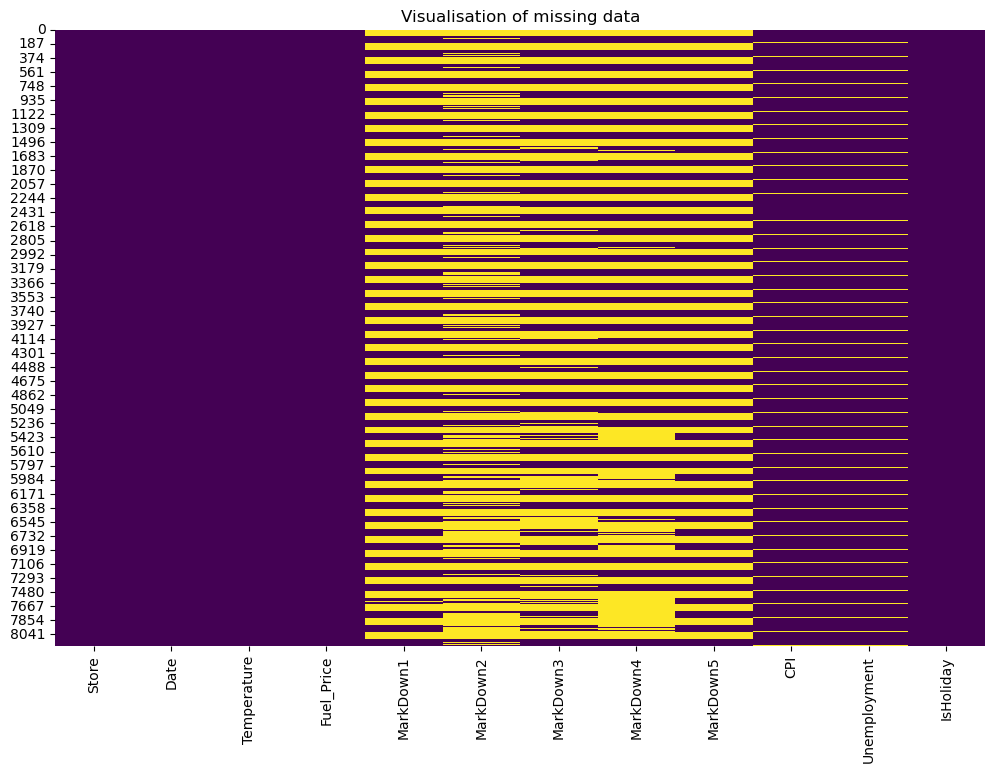

In [42]:
# checking of missing data in features

missing_values = features.isnull().sum()
missing_percent = (features.isnull().sum() / len(features)) * 100


missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percent': missing_percent})
print(missing_data)



plt.figure(figsize=(12, 8))
sns.heatmap(features.isnull(), cbar=False, cmap='viridis')
plt.title('Visualisation of missing data')
plt.show()

we can see that the amount of missing data in CPI and Unemployment is not high, so we can try to fix it but lets try concatenate features with train and test csv and check corelation matrix

In [43]:
cat_df=train.append(test, ignore_index=True)

grouped_cat=cat_df.groupby(['Store', 'Date']).agg({'Weekly_Sales': 'sum'}).reset_index()

grouped_cat['Date'] = pd.to_datetime(grouped_cat['Date'])
features['Date'] = pd.to_datetime(features['Date'])
merged_data_WO_imp = pd.merge(grouped_cat, features, on=['Store', 'Date'], how='left')

print(f'Liczba wierszy w grouped_data: {len(grouped_cat)}')
print(f'Liczba wierszy w merged_data: {len(merged_data_WO_imp)}')


Liczba wierszy w grouped_data: 8190
Liczba wierszy w merged_data: 8190


C:\Users\wojtek\AppData\Local\Temp\ipykernel_18464\2525196632.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cat_df=train.append(test, ignore_index=True)


In [44]:
# Inicjalizacja MICE Imputer
mice_imputer = IterativeImputer()
merged_data_W_imp=merged_data_WO_imp.copy()
# Imputacja danych
merged_data_W_imp[['CPI', 'Unemployment']] = mice_imputer.fit_transform(merged_data_WO_imp[['CPI', 'Unemployment']])

# Wyświetlenie brakujących wartości po imputacji
print('Missing data with imputer')
print(merged_data_WO_imp[['CPI', 'Unemployment']].isnull().sum())
print('Missing data without imputer')
print(merged_data_W_imp[['CPI', 'Unemployment']].isnull().sum())

Missing data with imputer
CPI             585
Unemployment    585
dtype: int64
Missing data without imputer
CPI             0
Unemployment    0
dtype: int64


Now compare corelation matrix between dataset with missing value CPI and Unemployment we dont compare markdown1-5 becasue stil have missing values

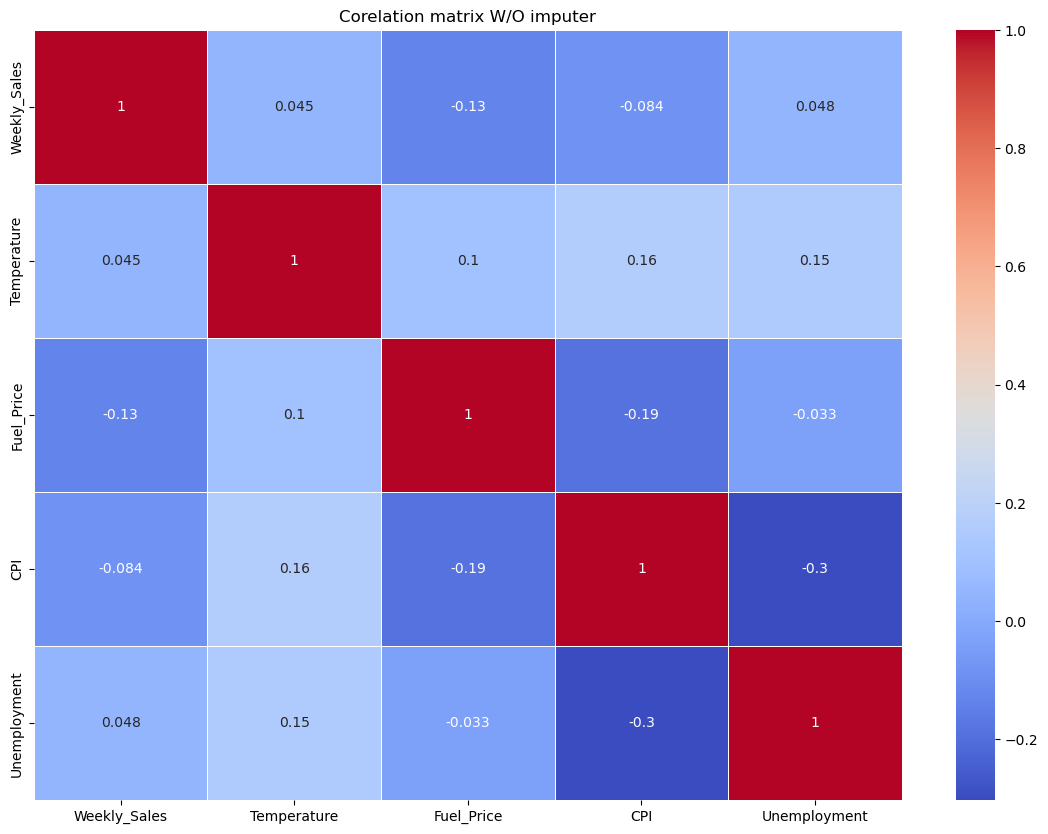

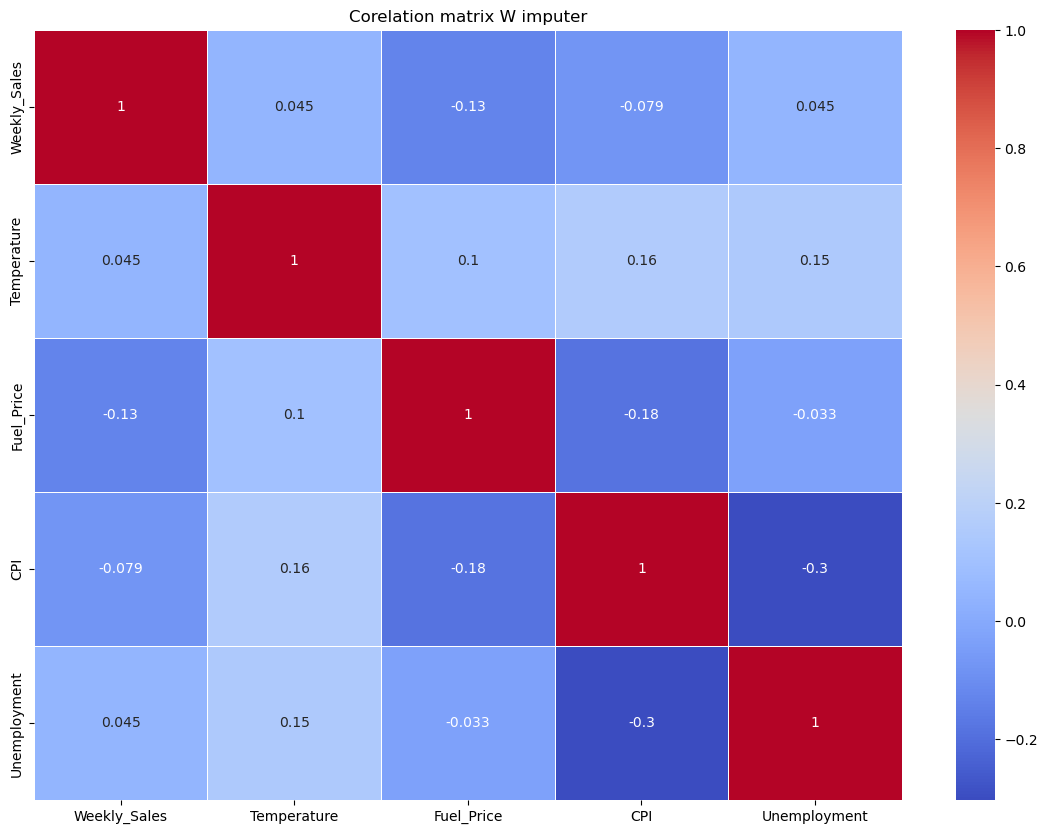

In [45]:

# Wybranie istotnych kolumn do analizy korelacji
corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Obliczenie macierzy korelacji
correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_W_imp = merged_data_W_imp[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_W_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

in my opinion imputer work good enought its small diferences between [CPI, Unemployment] and Weekly_Sales

We ned to decide what to do with markdown1-5

In [46]:
# test shapiro
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
shapiro_results={}

for col in markdown_columns:
    data = merged_data_W_imp[col].dropna()
        # Wykonanie testu
    stat, p_value = shapiro(data)
        # Zapisanie wyników
    shapiro_results[col] = {'statistic': stat, 'p-value': p_value}

for col, result in shapiro_results.items():
    print(f'{col}: W-statistic={result["statistic"]}, p-value={result["p-value"]}')



MarkDown1: W-statistic=0.6378118395805359, p-value=0.0
MarkDown2: W-statistic=0.4161747694015503, p-value=0.0
MarkDown3: W-statistic=0.13968408107757568, p-value=0.0
MarkDown4: W-statistic=0.46672219038009644, p-value=0.0
MarkDown5: W-statistic=0.10974830389022827, p-value=0.0


So this isn't normal distrribution 

In [47]:
from sklearn.impute import KNNImputer

merged_data_no_empty=merged_data_W_imp.copy()

# Inicjalizacja KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Imputacja danych
merged_data_no_empty[markdown_columns] = knn_imputer.fit_transform(merged_data_no_empty[markdown_columns])

# Sprawdzenie brakujących wartości po imputacji
print('Missing data after KNN imputation:')
print(merged_data_no_empty[markdown_columns].isnull().sum())


Missing data after KNN imputation:
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


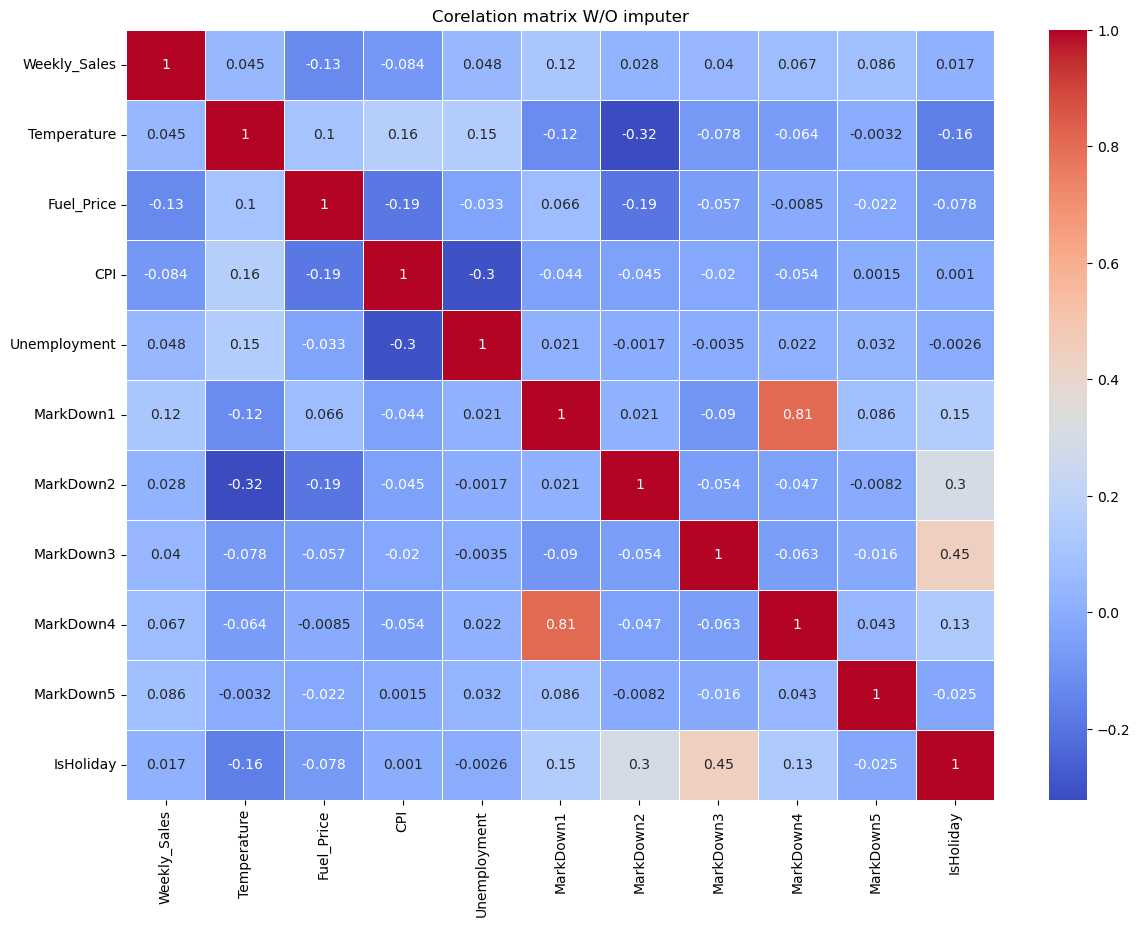

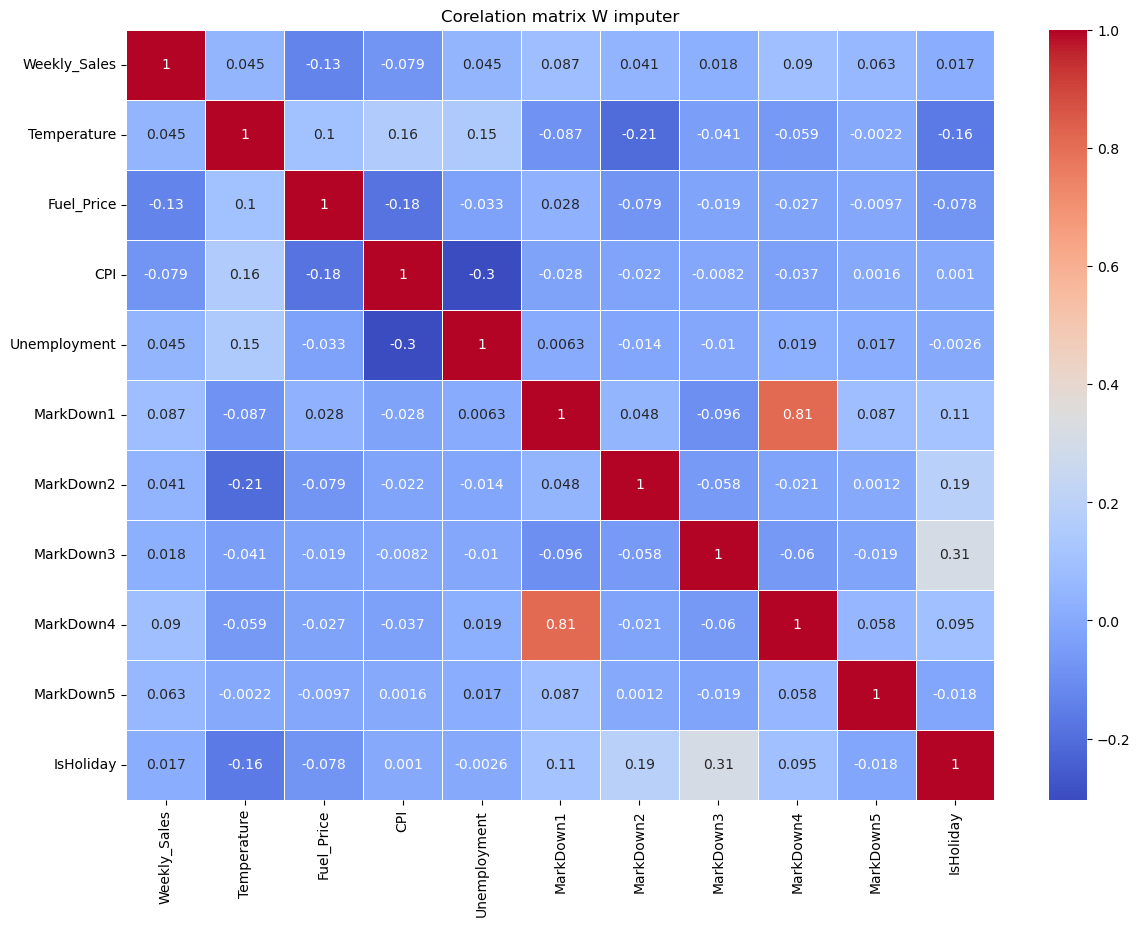

In [62]:
# Wybranie istotnych kolumn do analizy korelacji
corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']

# Obliczenie macierzy korelacji
correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_no_empty = merged_data_no_empty[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_no_empty, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

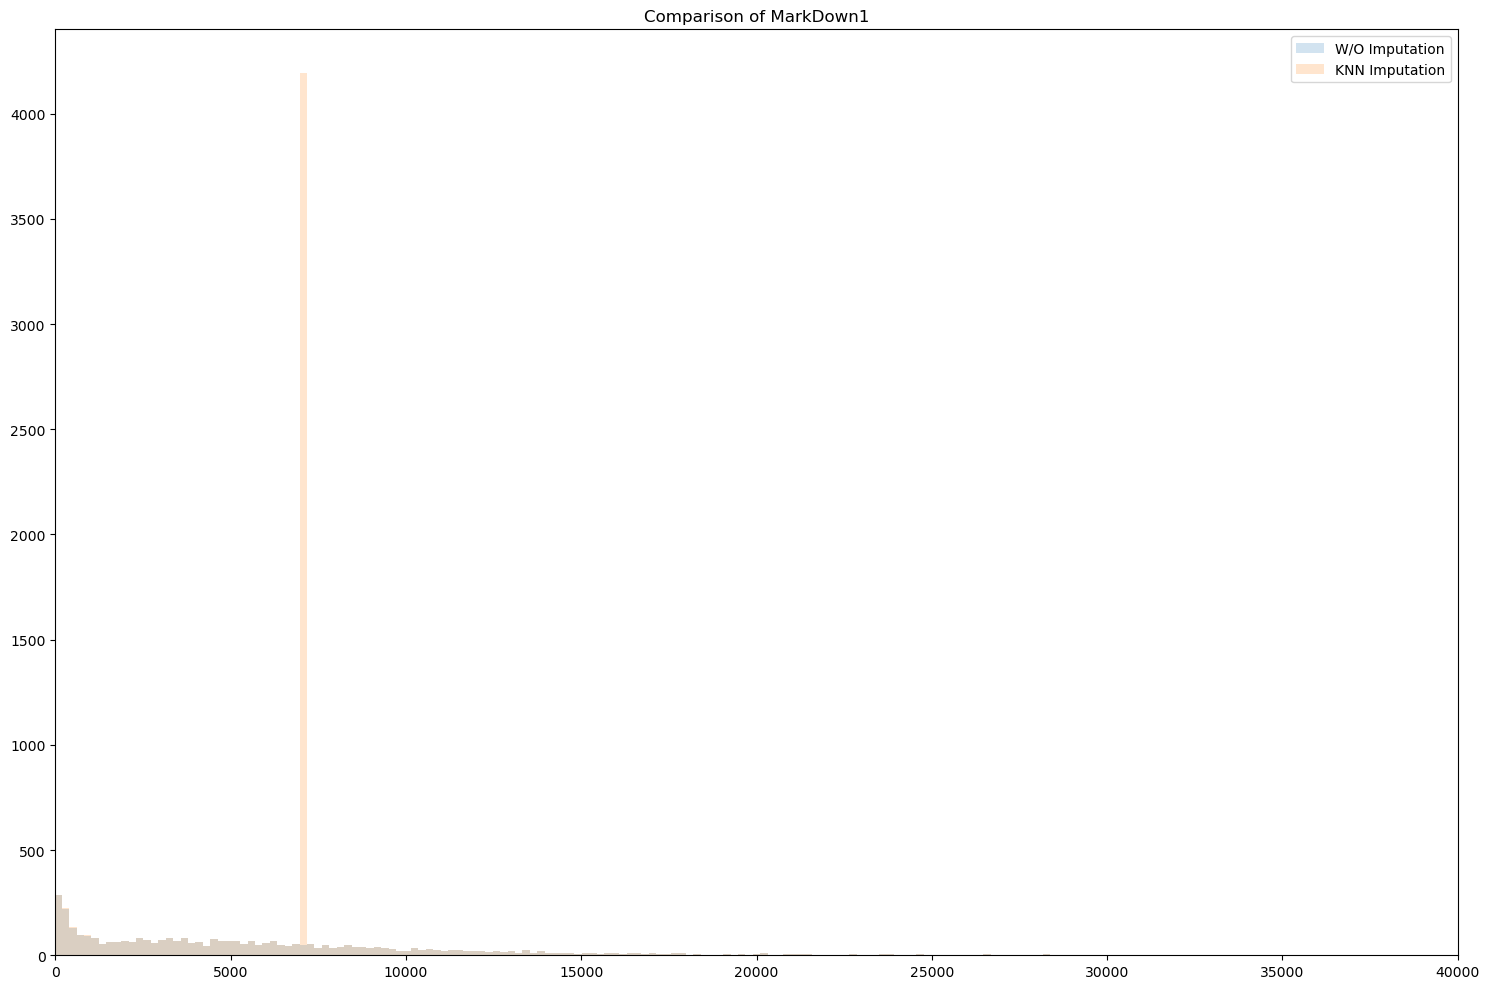

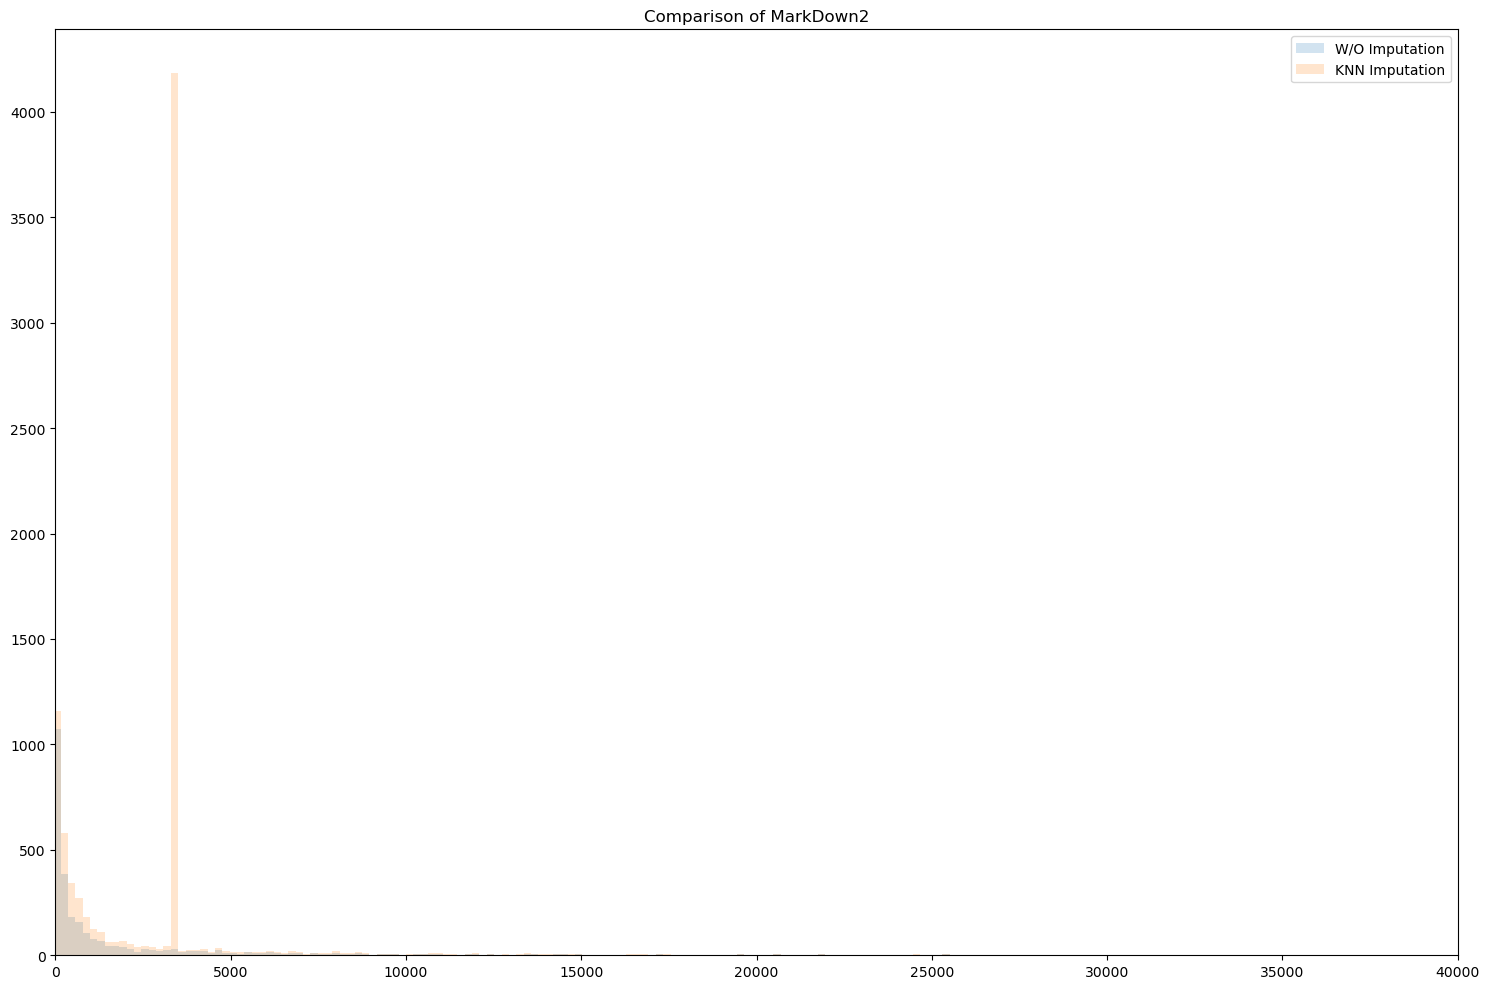

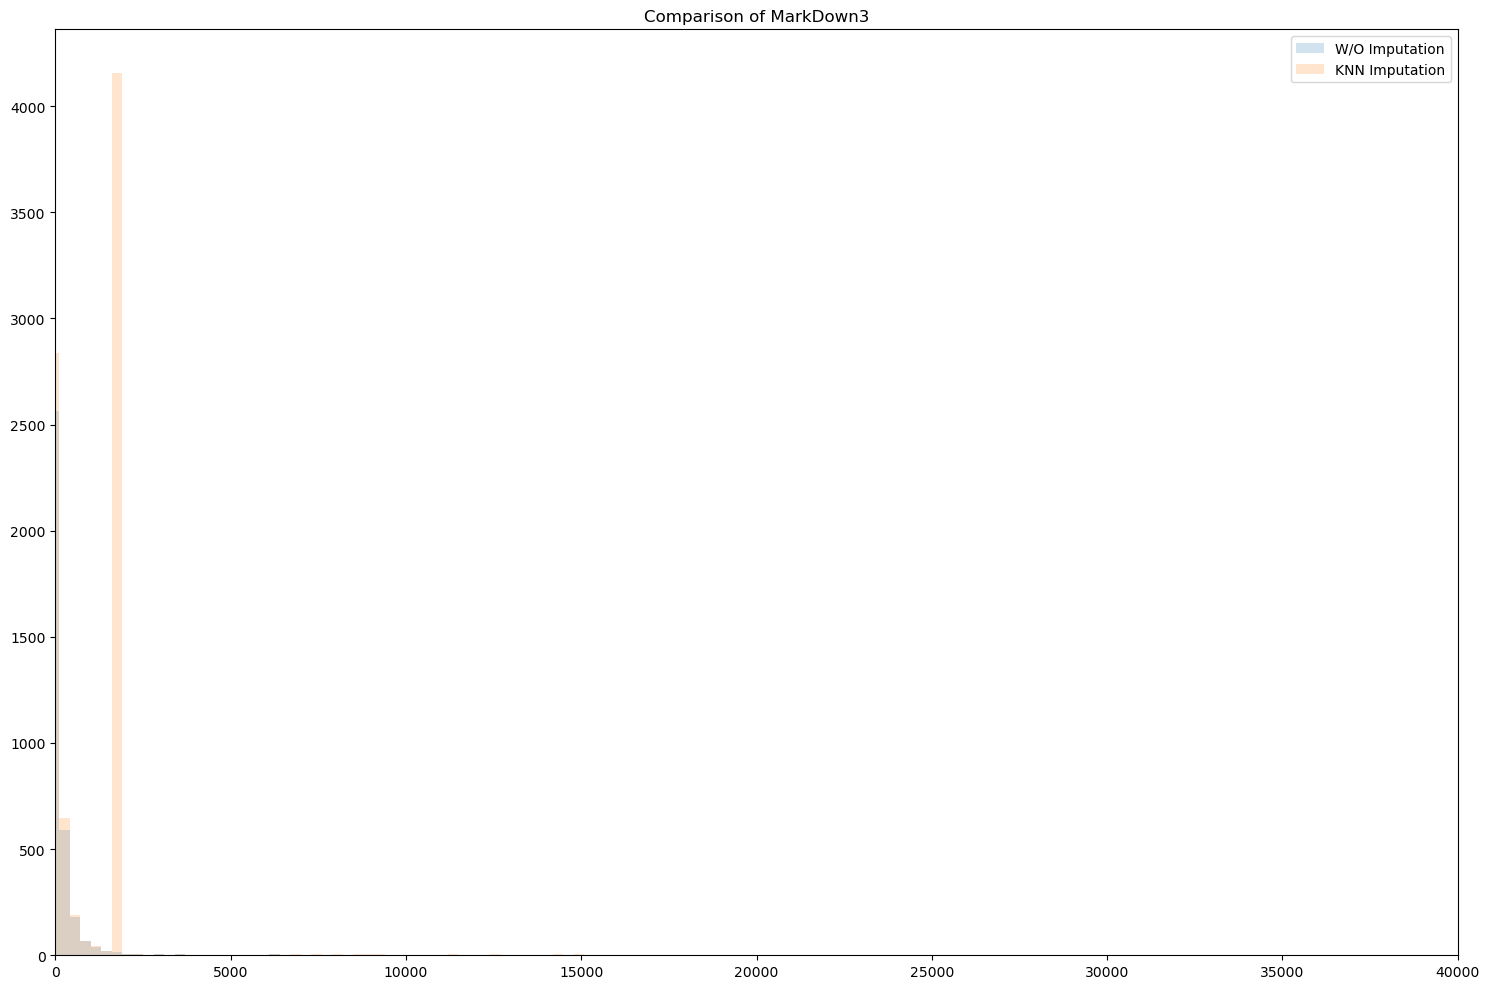

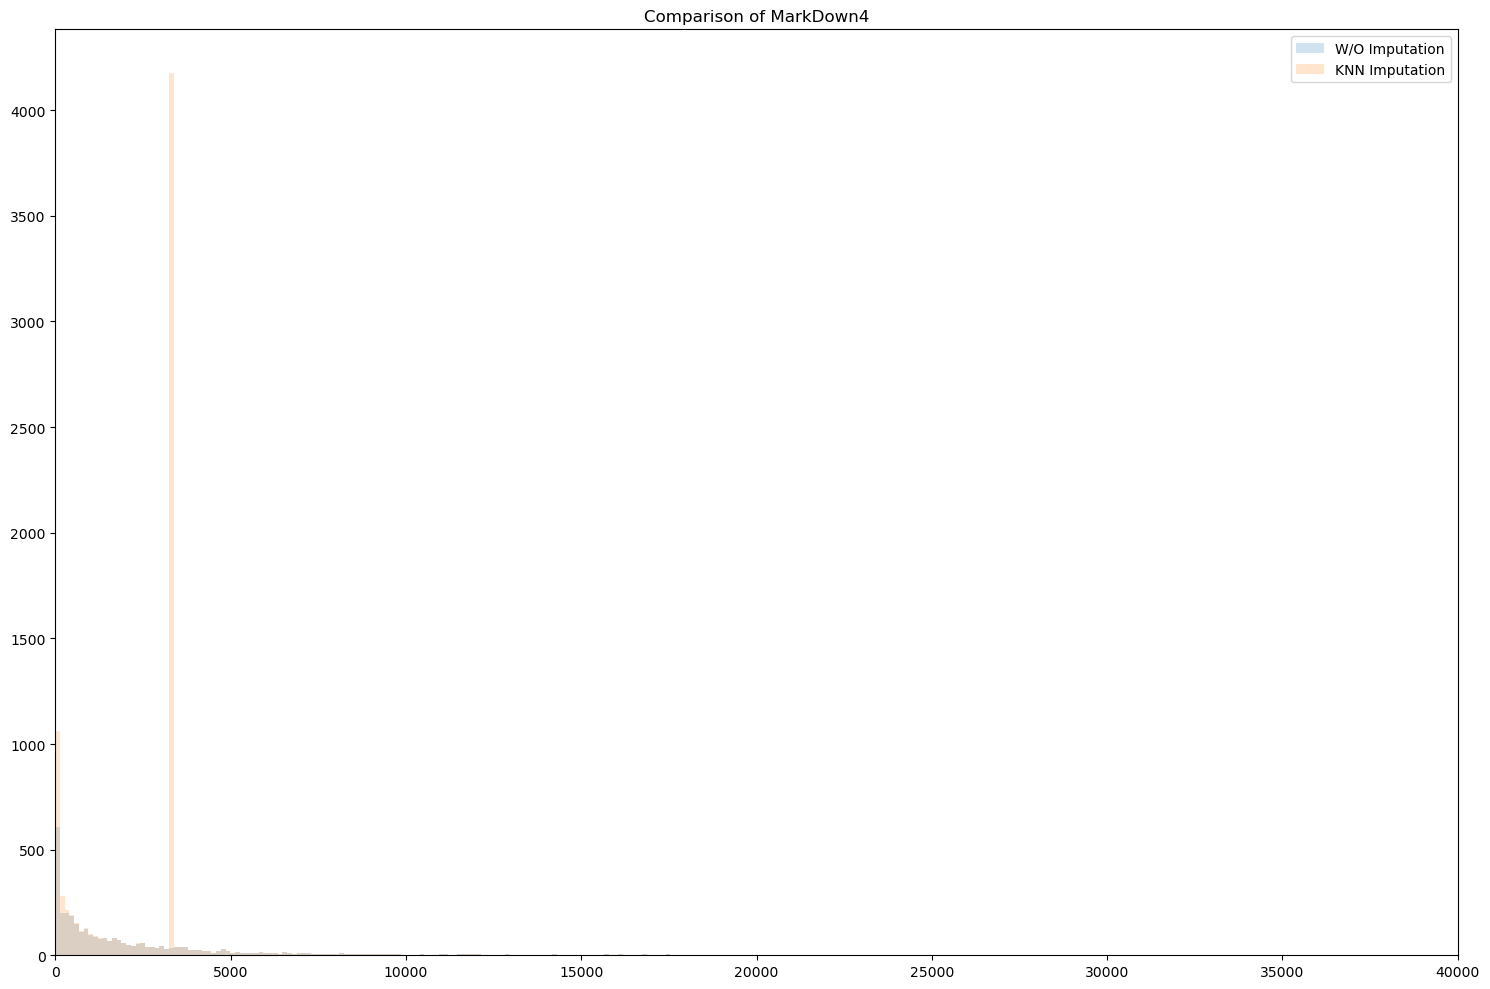

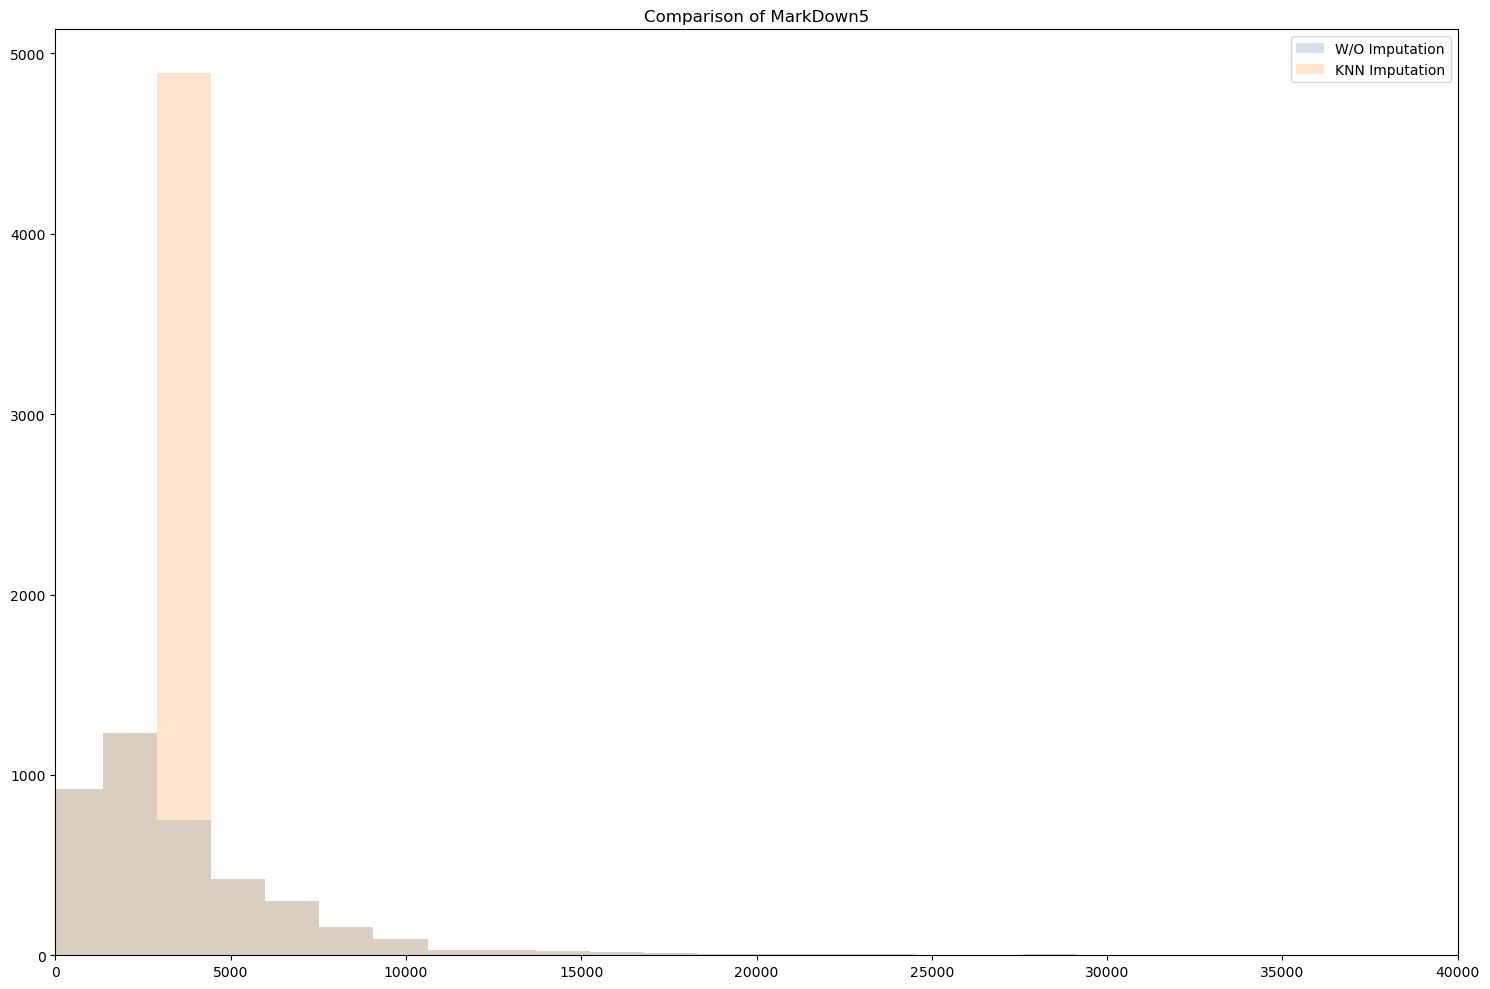

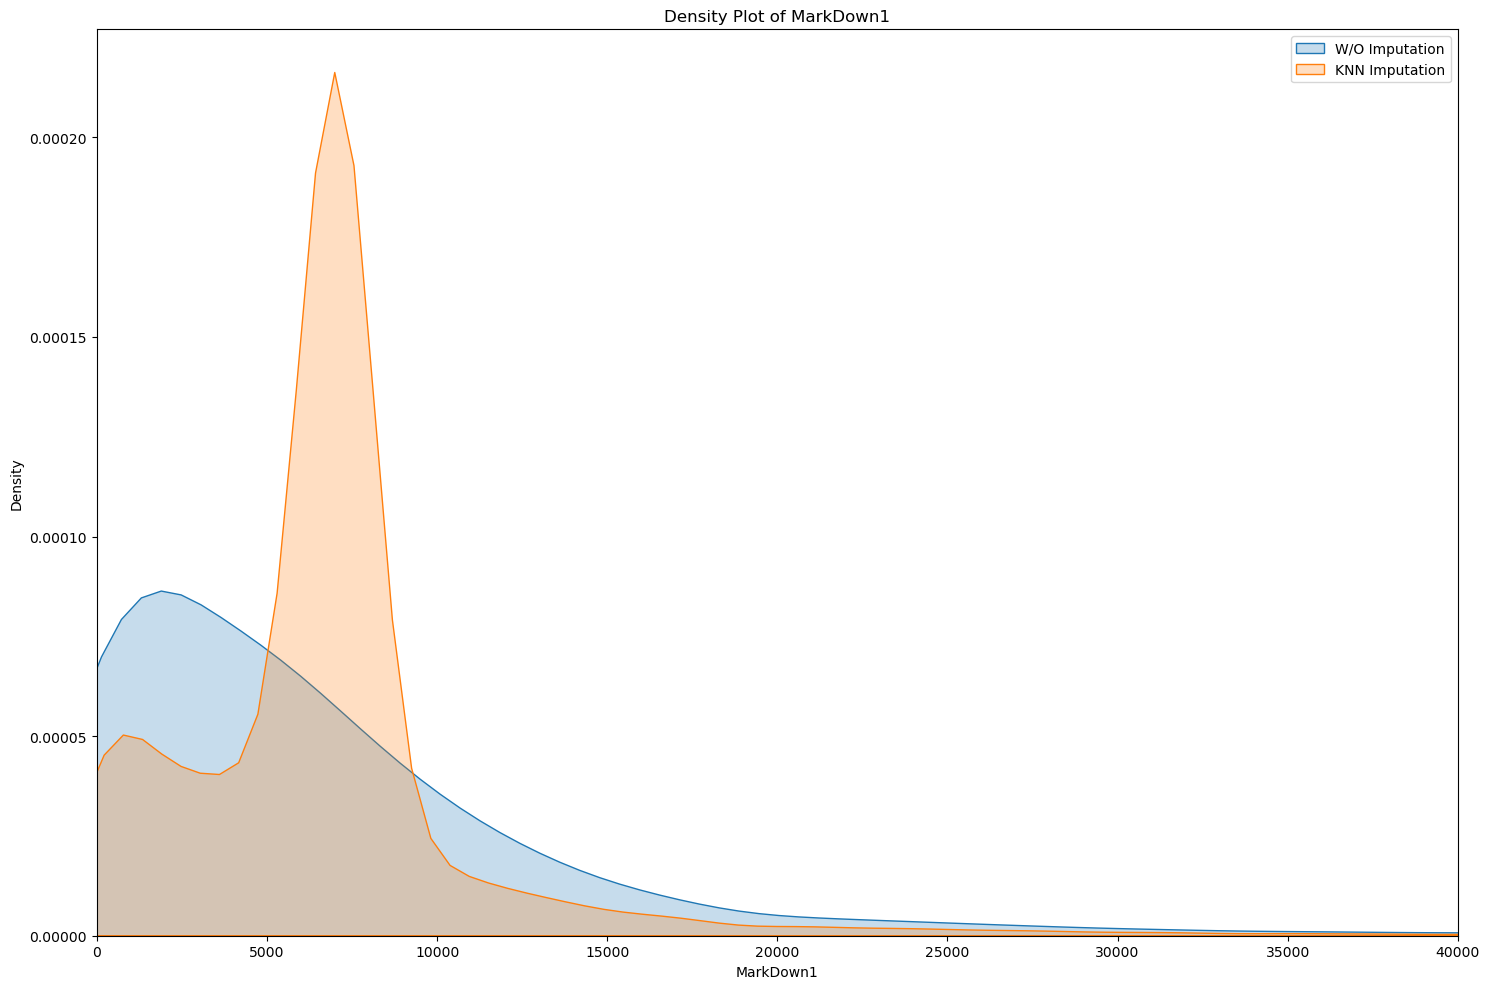

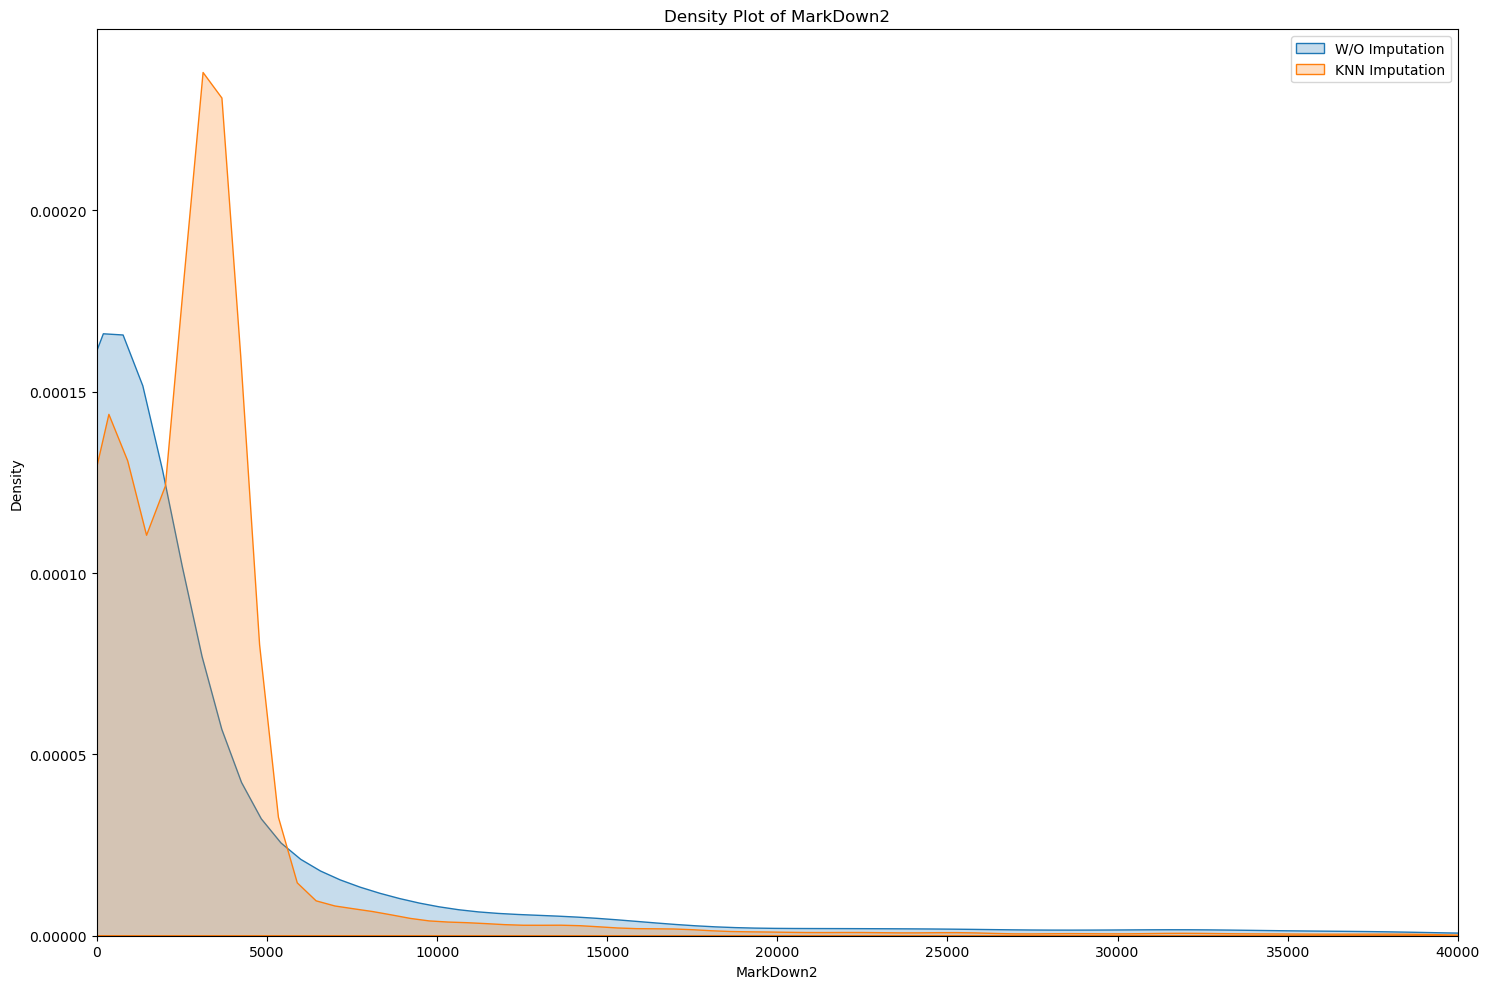

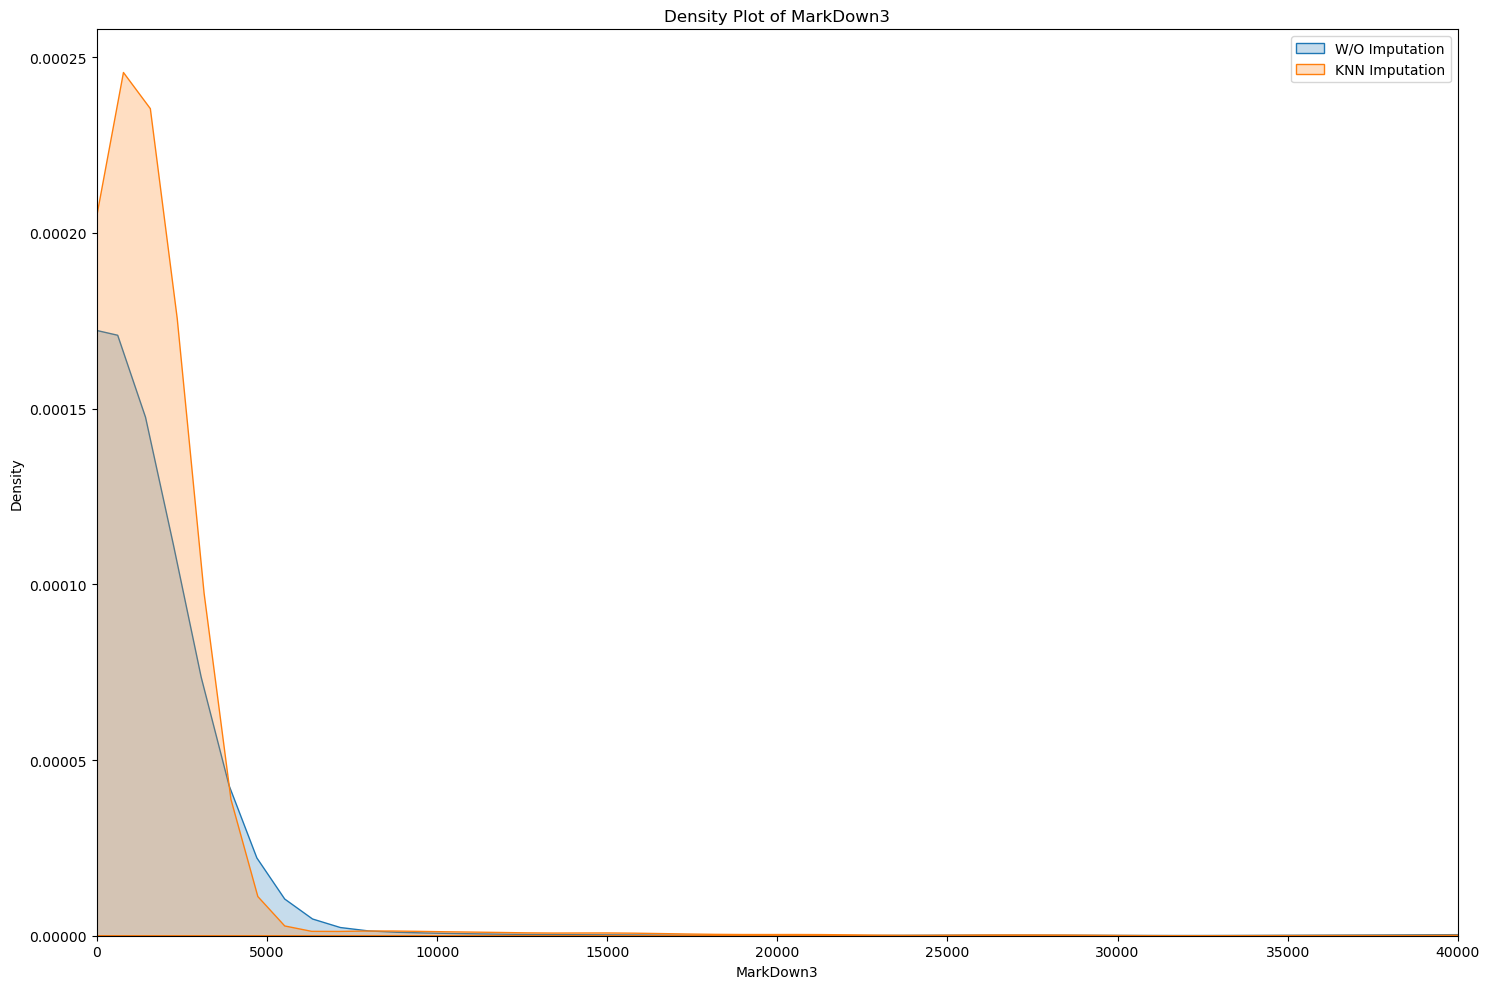

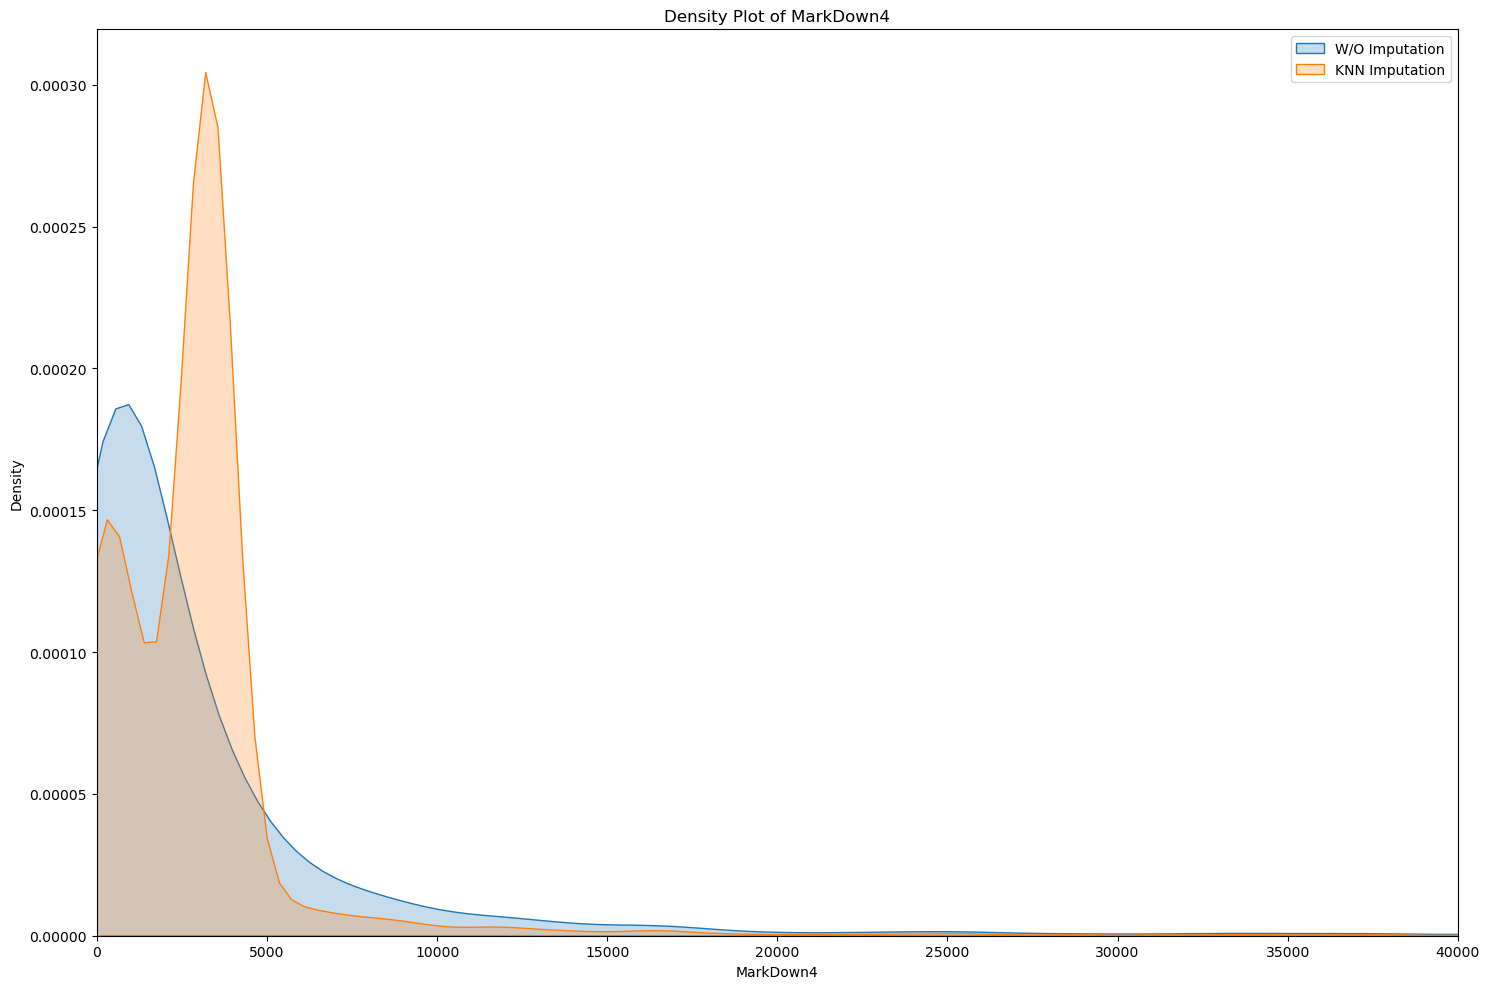

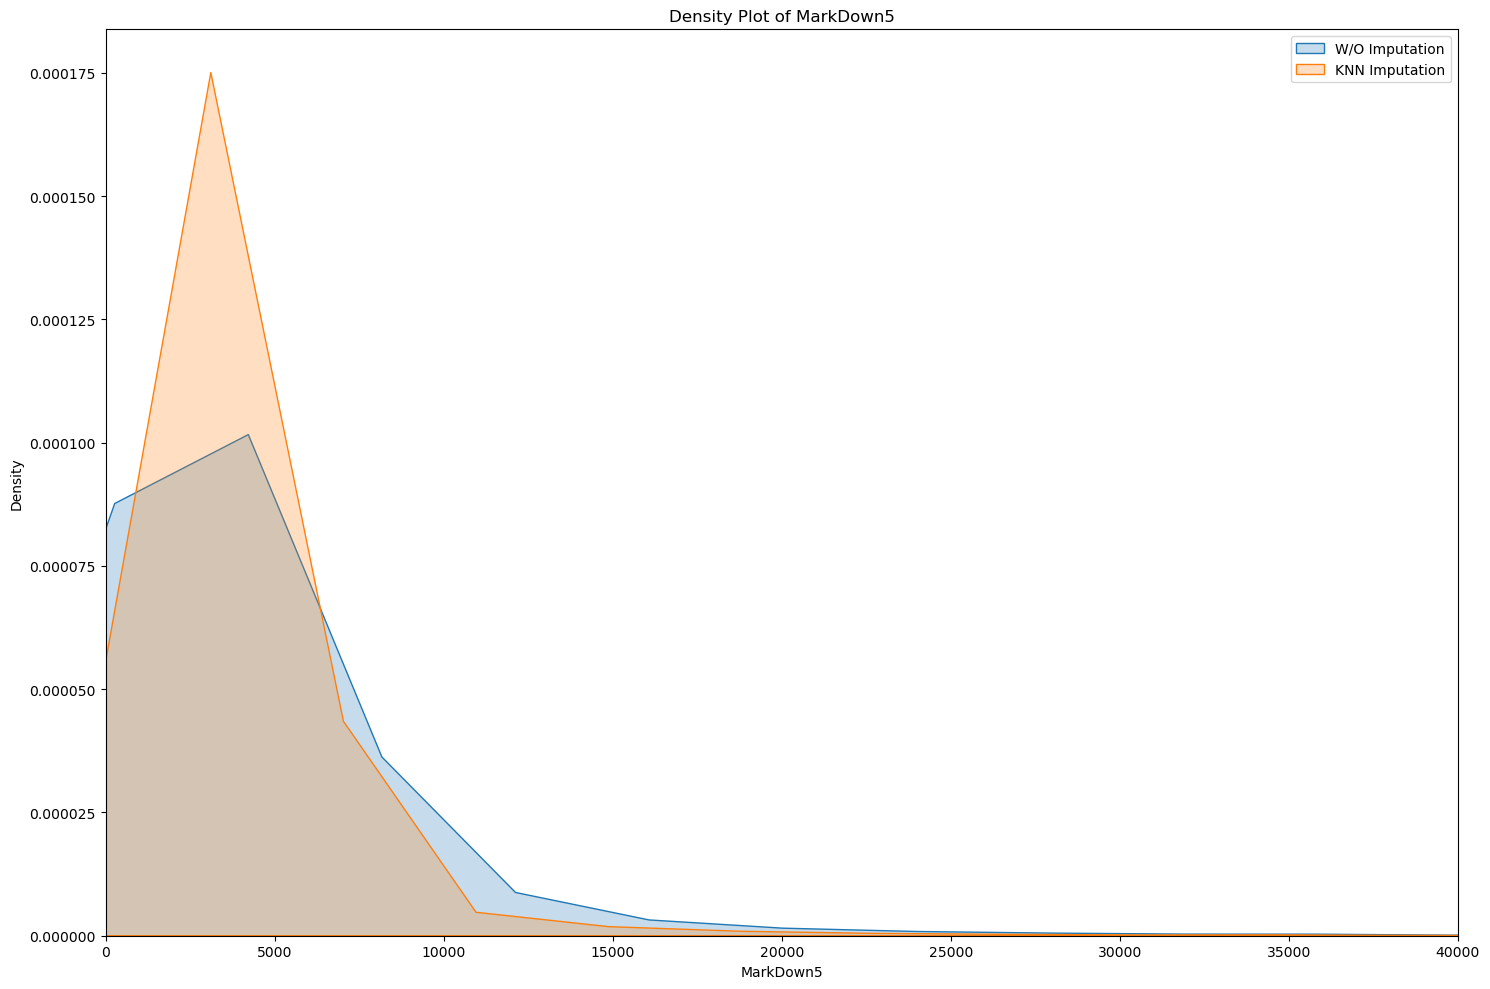

In [57]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Wizualizacja porównawcza rozkładów danych


for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    plt.hist(merged_data_W_imp[col].dropna(), bins=500, alpha=0.2, label='W/O Imputation')
    plt.hist(merged_data_no_empty[col].dropna(), bins=500, alpha=0.2, label='KNN Imputation')
    plt.xlim(0, 40000)
    plt.title(f'Comparison of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()



# plt.figure(figsize=(15, 10))

# for i, col in enumerate(markdown_columns, start=1):
#     # plt.subplot(6, 1, i)
#     plt.boxplot([merged_data_W_imp[col].dropna(), merged_data_no_empty[col].dropna()], labels=['W/O ', 'KNN'])
#     plt.title(f'Box Plot of {col}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()



for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    sns.kdeplot(merged_data_W_imp[col].dropna(), shade=True, label='W/O Imputation')
    sns.kdeplot(merged_data_no_empty[col].dropna(), shade=True, label='KNN Imputation')
    plt.xlim(0, 40000)
    plt.title(f'Density Plot of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()









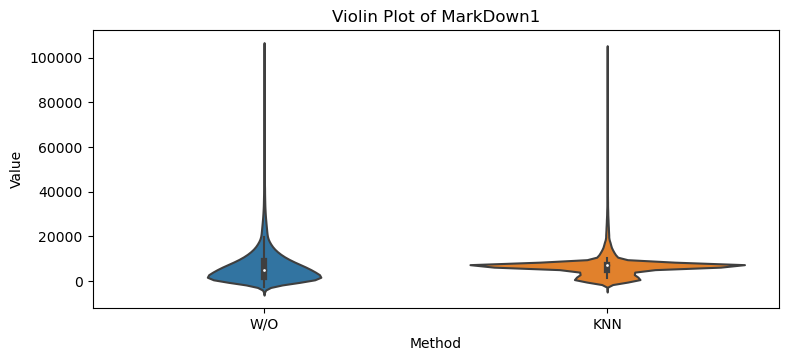

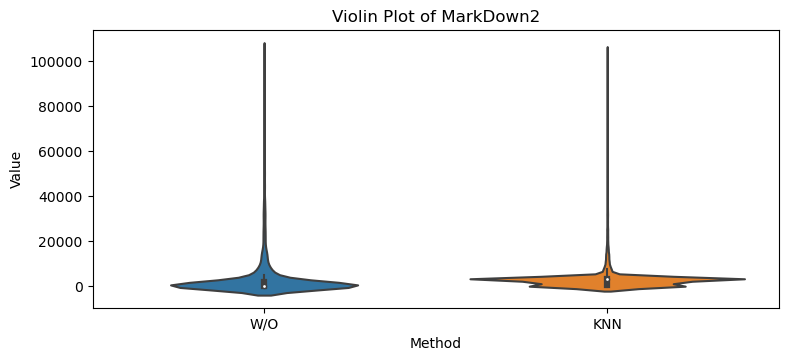

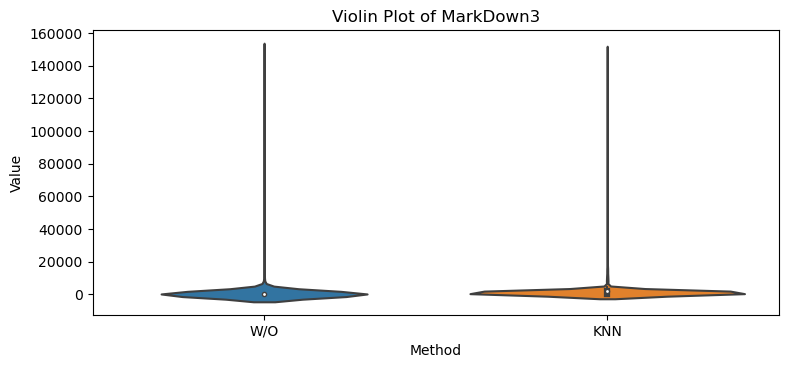

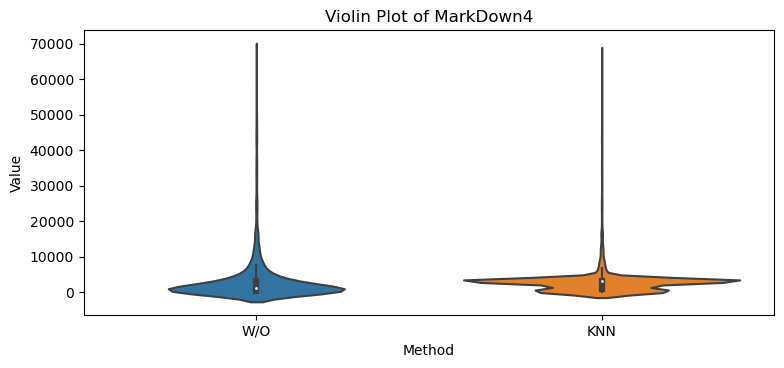

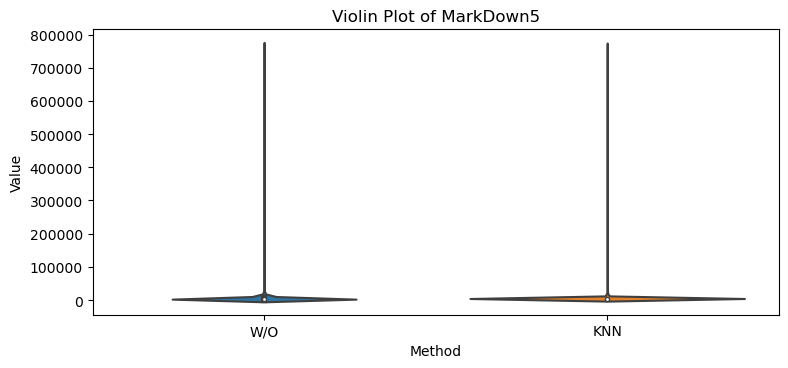

In [54]:
data_melted = pd.DataFrame()
for col in markdown_columns:
    temp_df = pd.DataFrame({
        'Value': merged_data_W_imp[col].dropna(),
        'Column': col,
        'Method': 'W/O'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)
    
    temp_df = pd.DataFrame({
        'Value': merged_data_no_empty[col].dropna(),
        'Column': col,
        'Method': 'KNN'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)

# Wizualizacja porównawcza rozkładów danych za pomocą violin plotów


for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 2, i)
    sns.violinplot(x='Method', y='Value', data=data_melted[data_melted['Column'] == col])
    plt.title(f'Violin Plot of {col}')
    plt.tight_layout()
    plt.show()



as we can see above knn didn't work very well
how does median imputing work?

In [58]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

merged_data_median_imp=merged_data_W_imp.copy()
for col in markdown_columns:
    if col in merged_data_median_imp.columns:
        median_value = merged_data_median_imp[col].median()
        merged_data_median_imp[col].fillna(median_value, inplace=True)

# Sprawdzenie brakujących wartości po imputacji
print('Missing data after median imputation:')
print(merged_data_median_imp[markdown_columns].isnull().sum())

Missing data after median imputation:
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


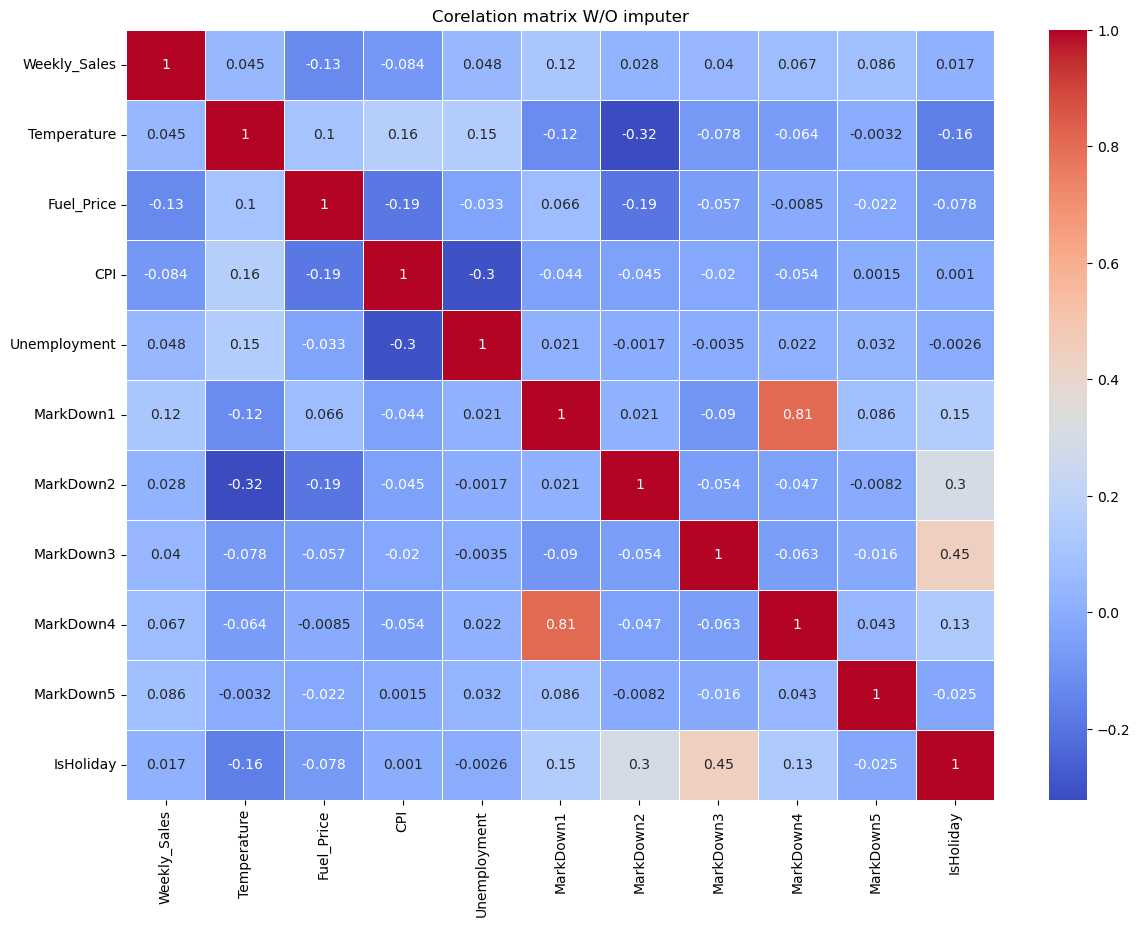

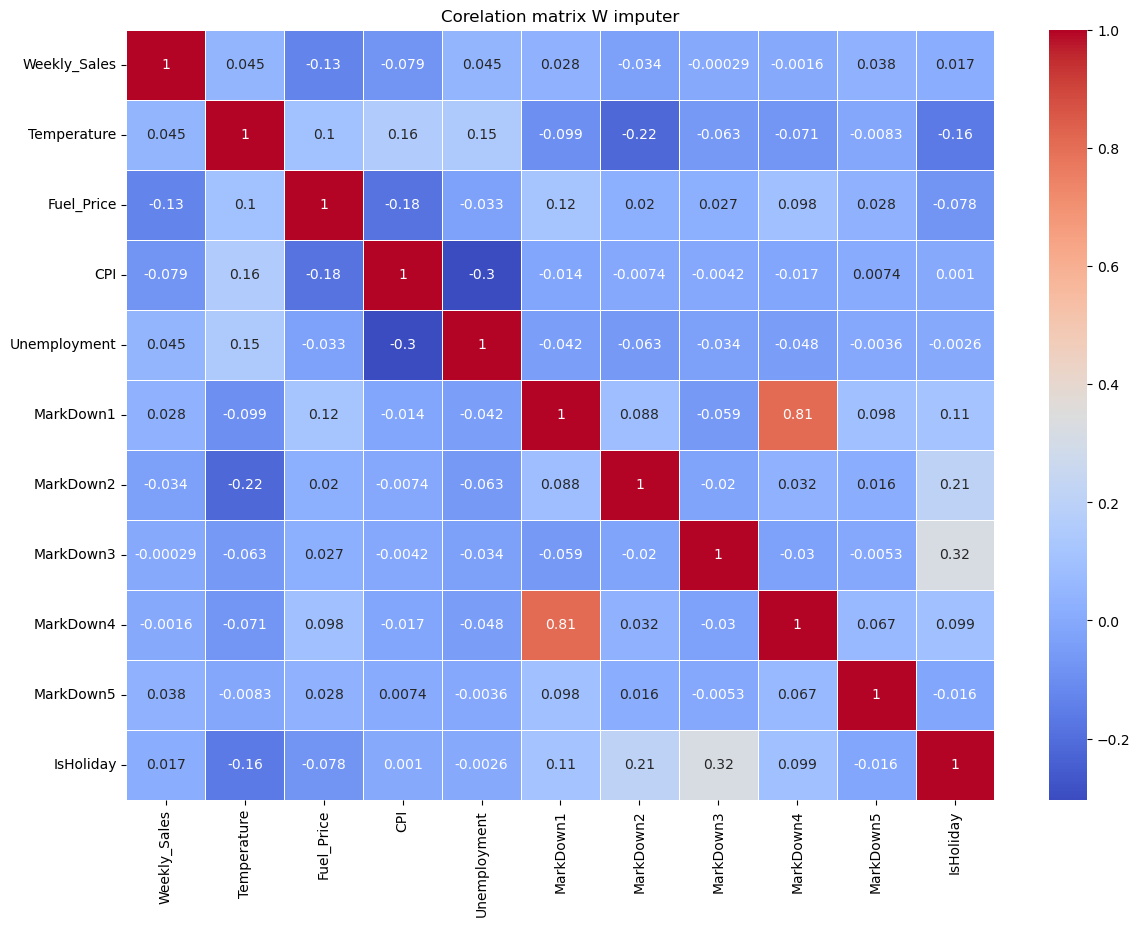

In [61]:
# Wybranie istotnych kolumn do analizy korelacji
corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']

# Obliczenie macierzy korelacji
correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_median_imp = merged_data_median_imp[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_median_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

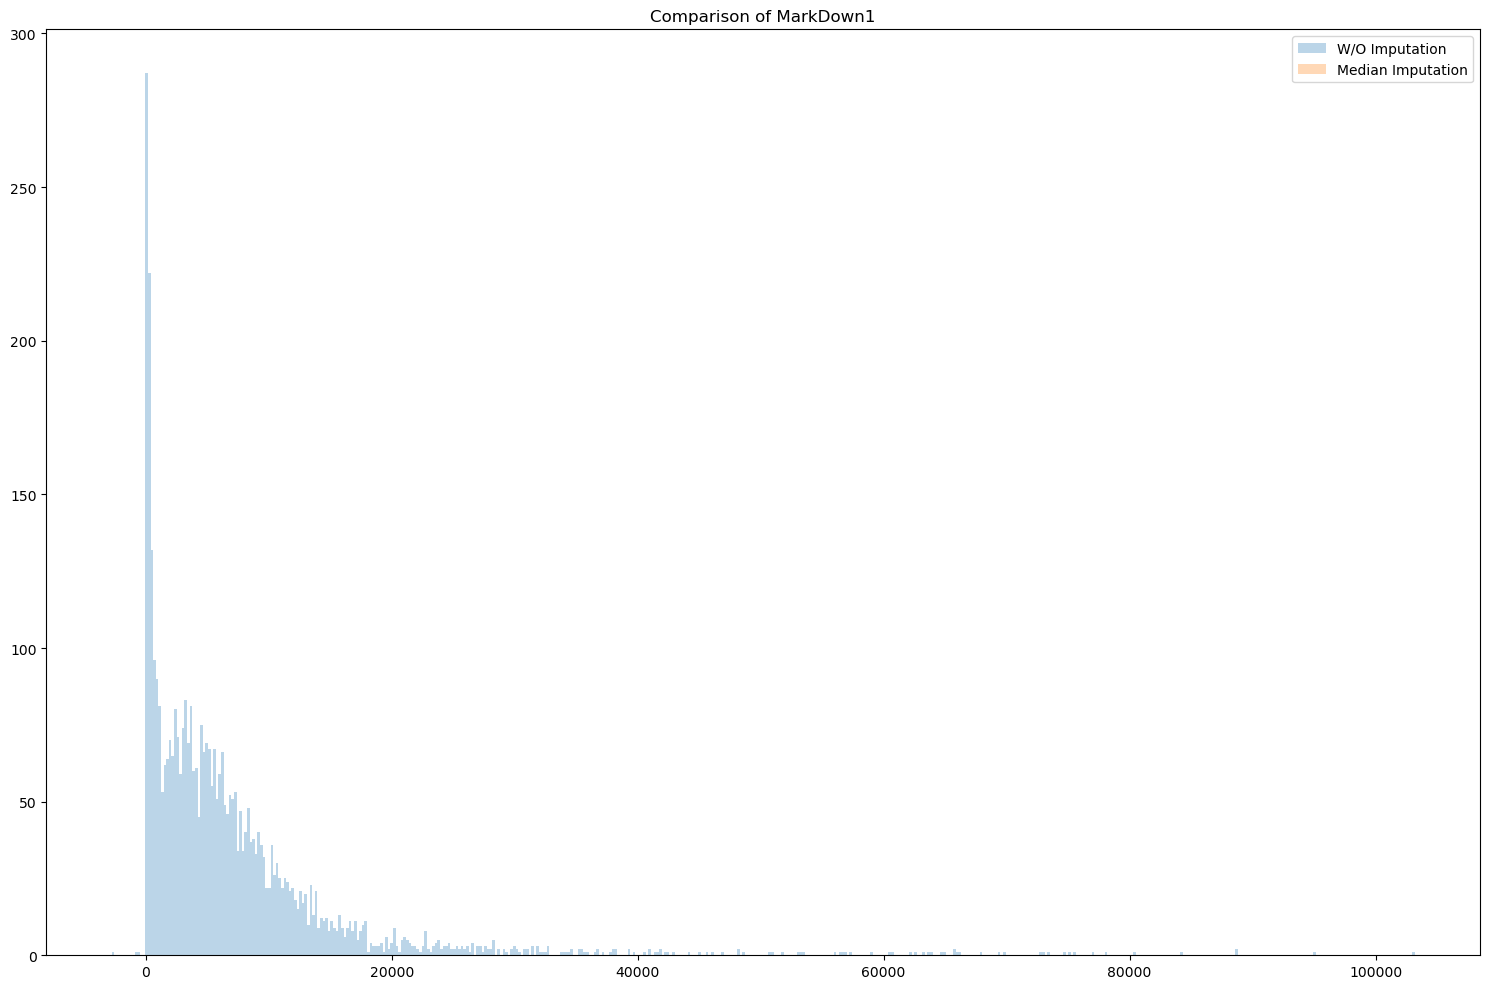

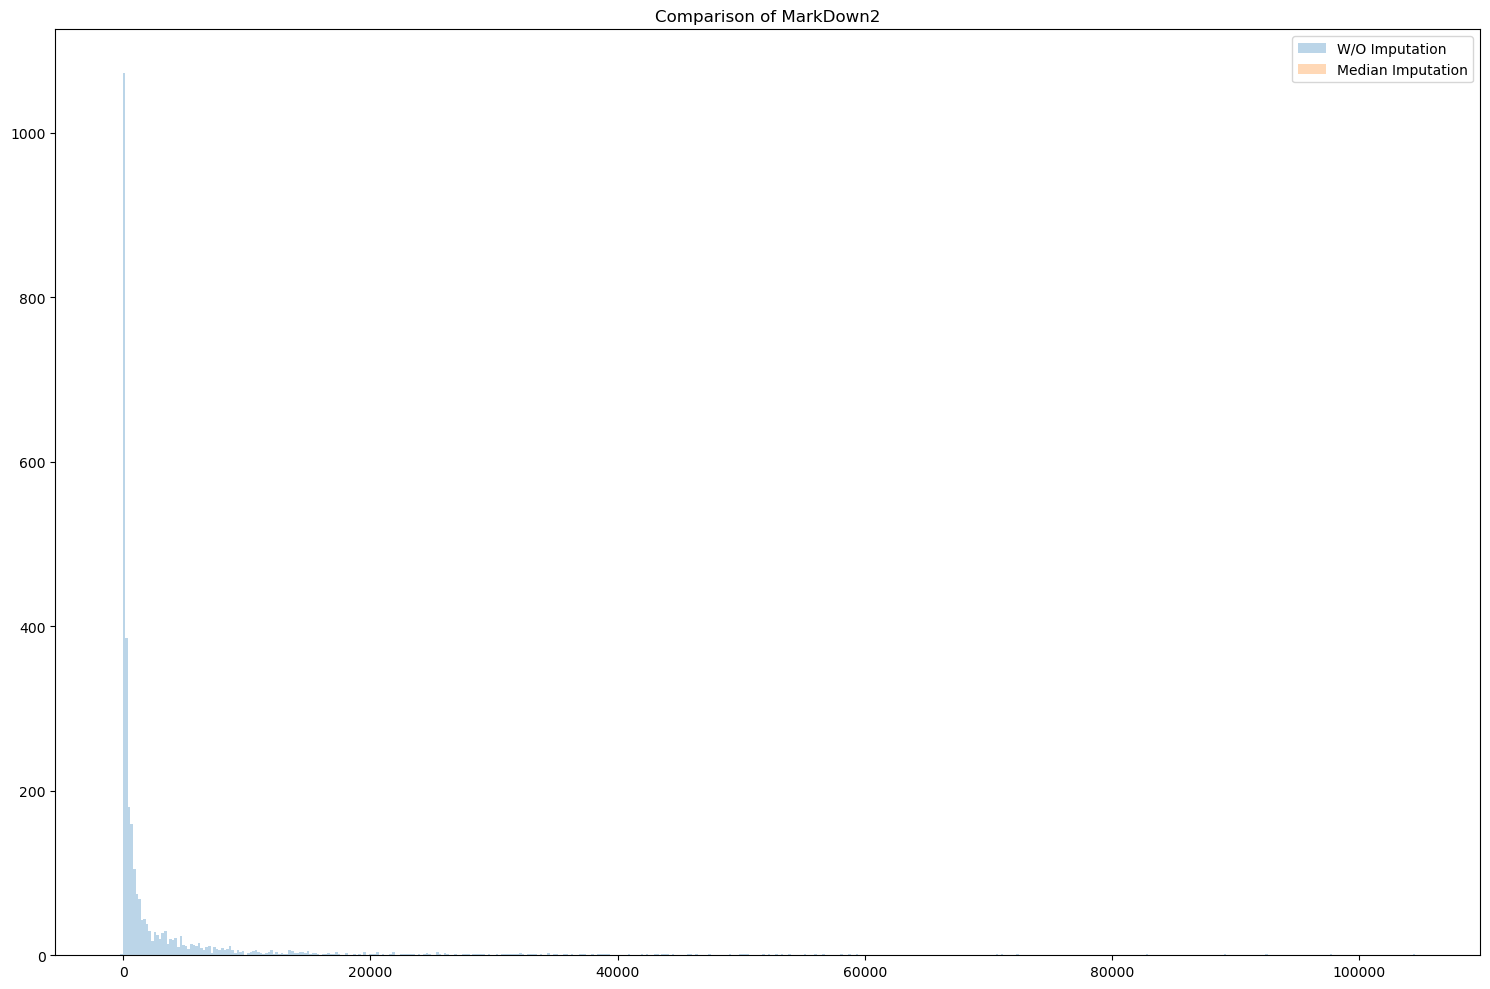

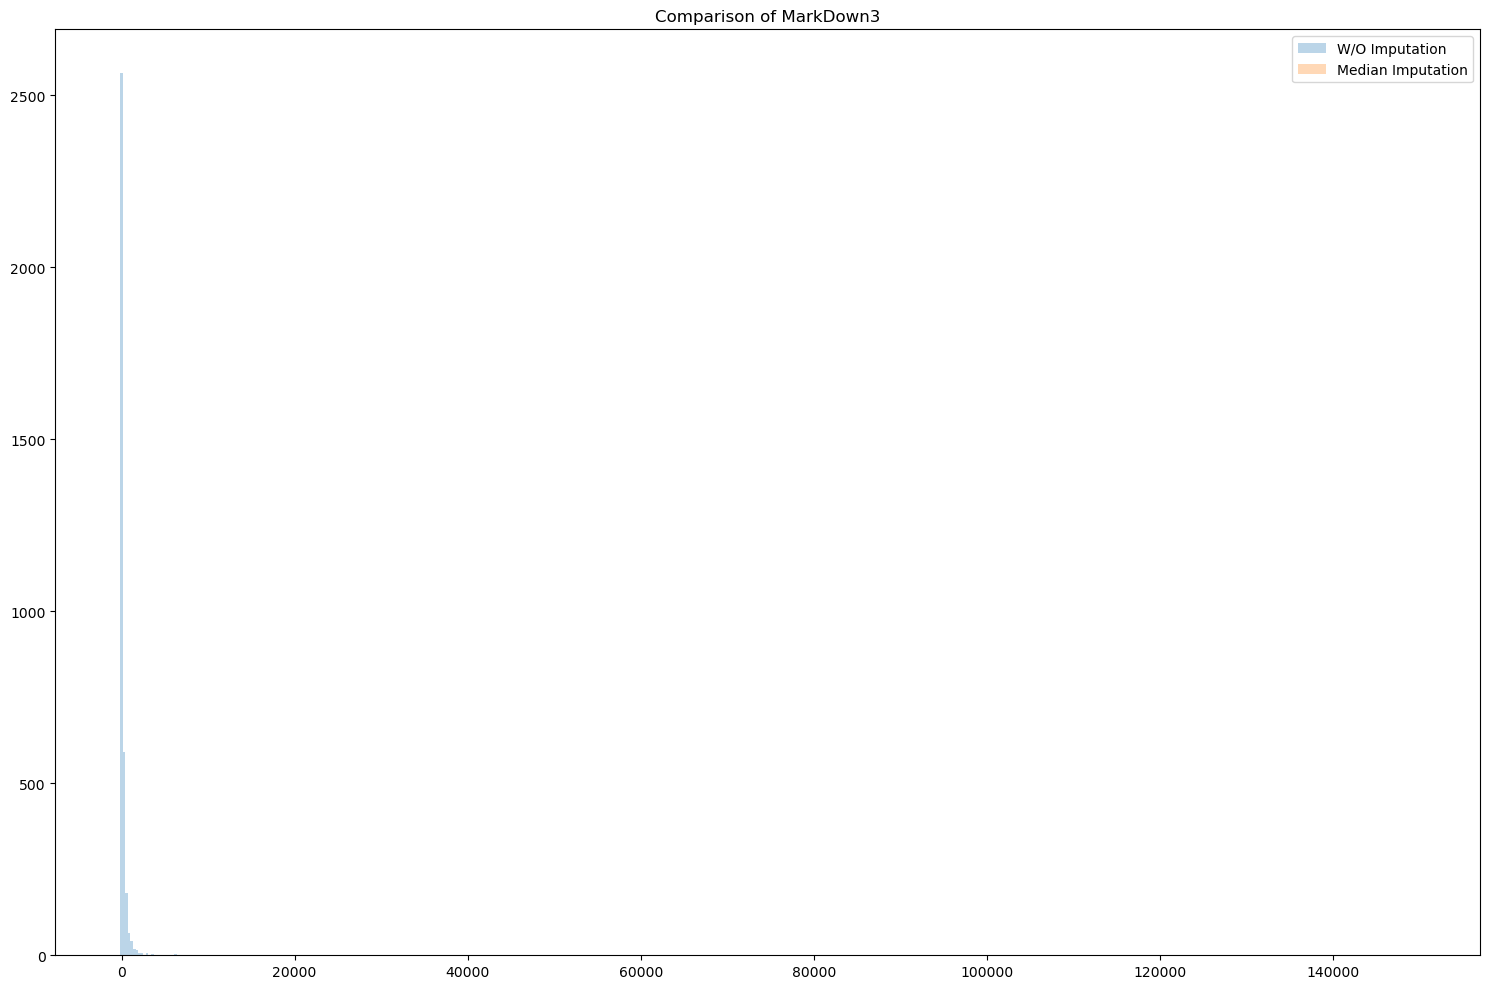

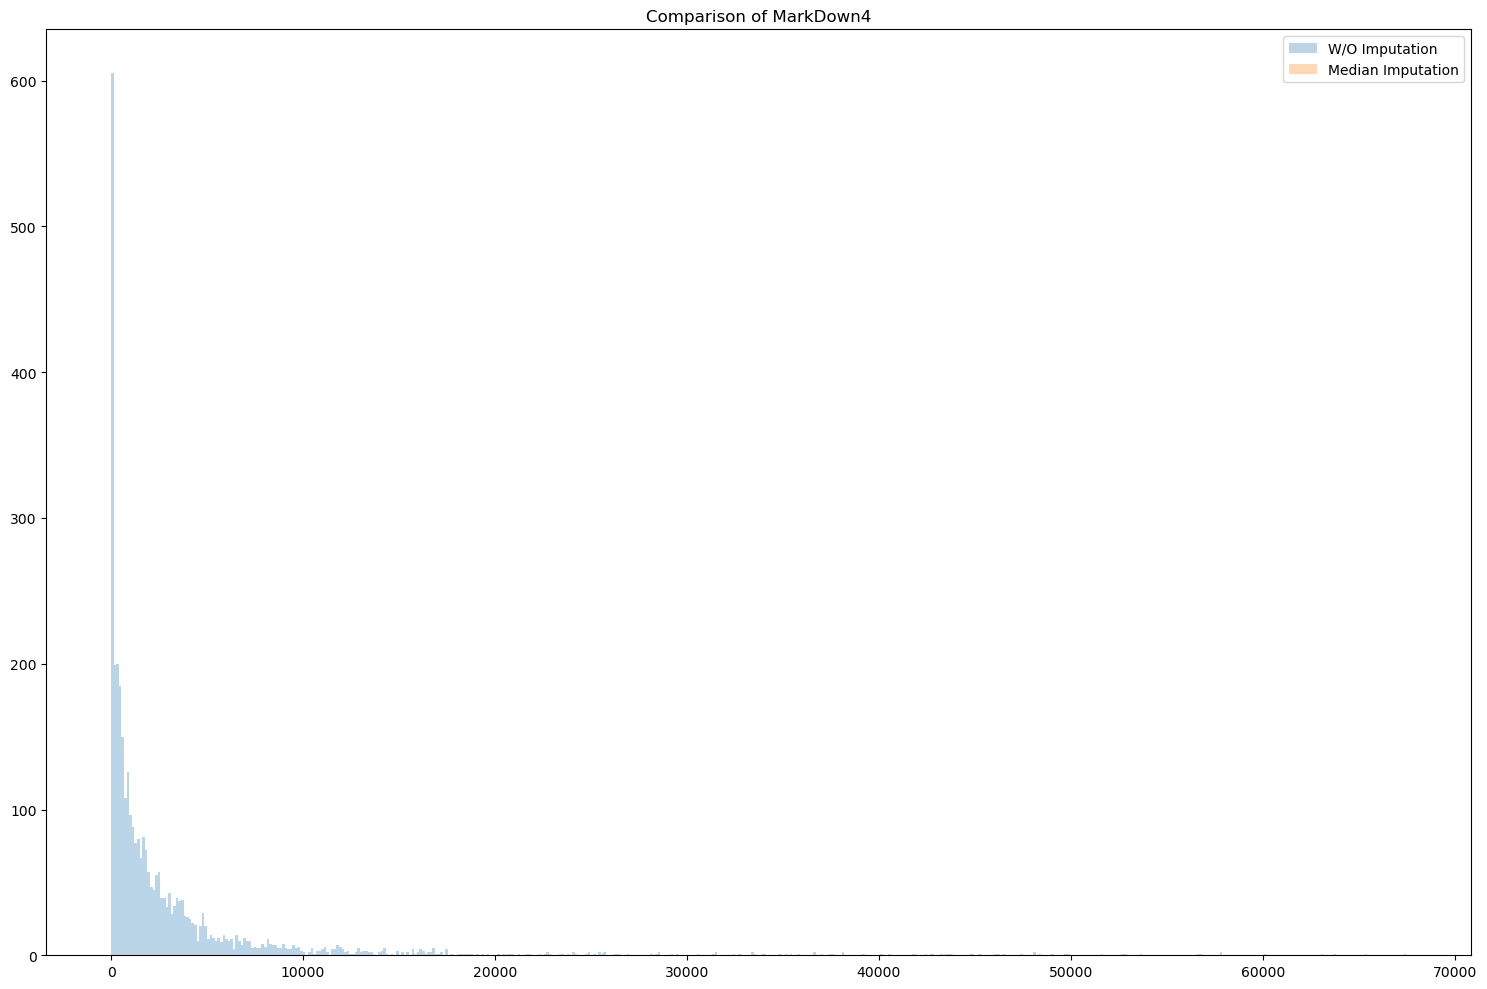

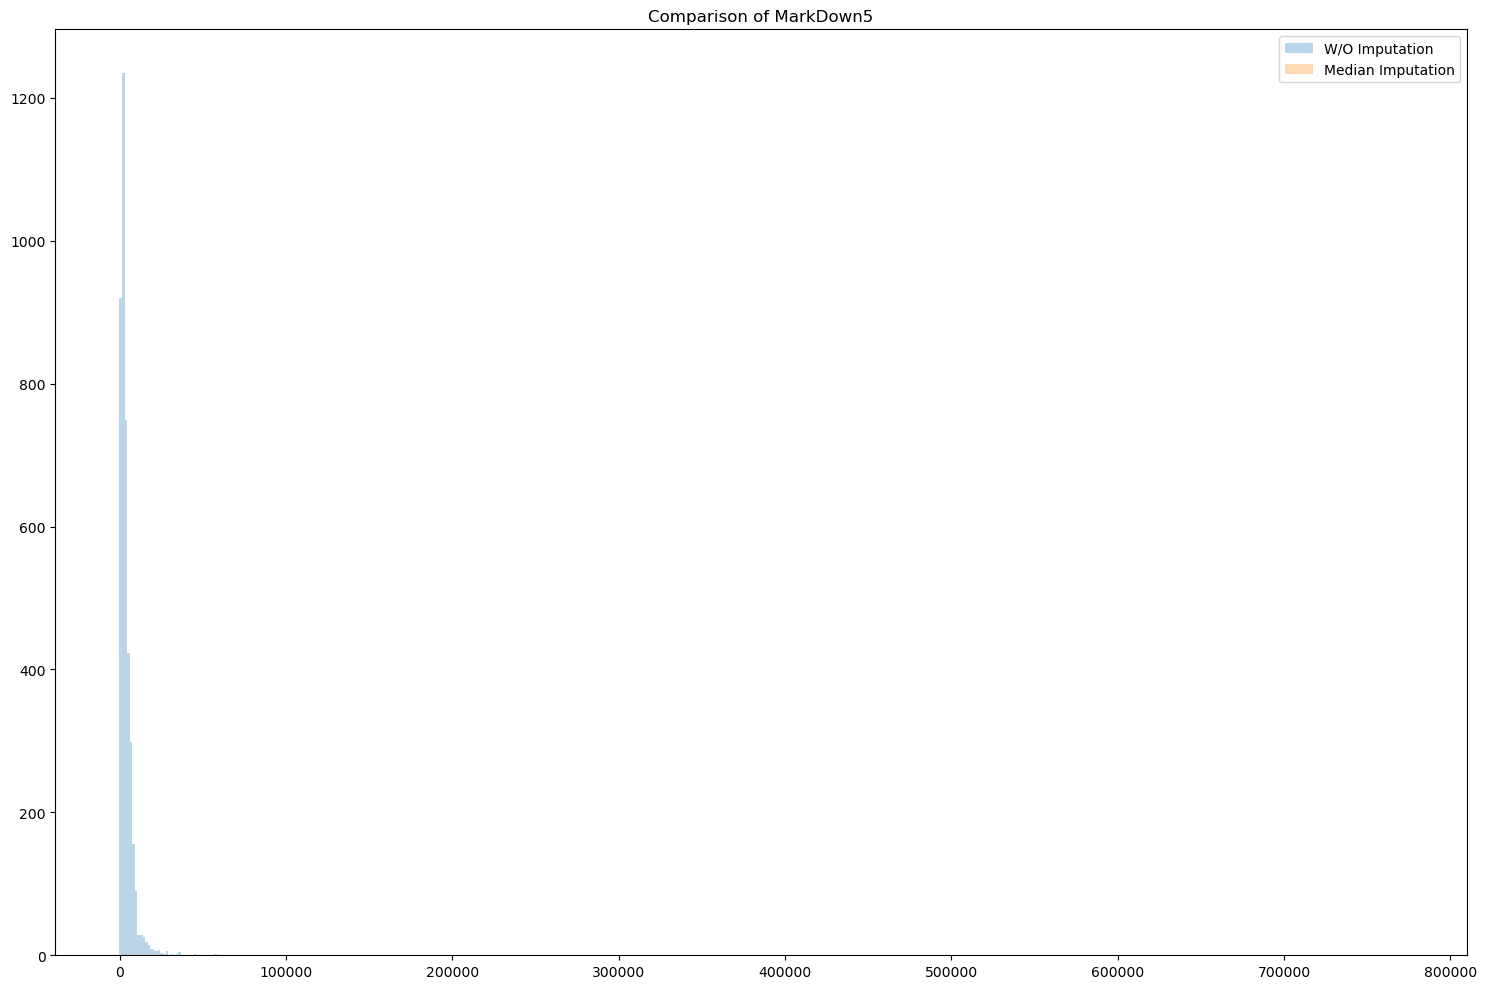

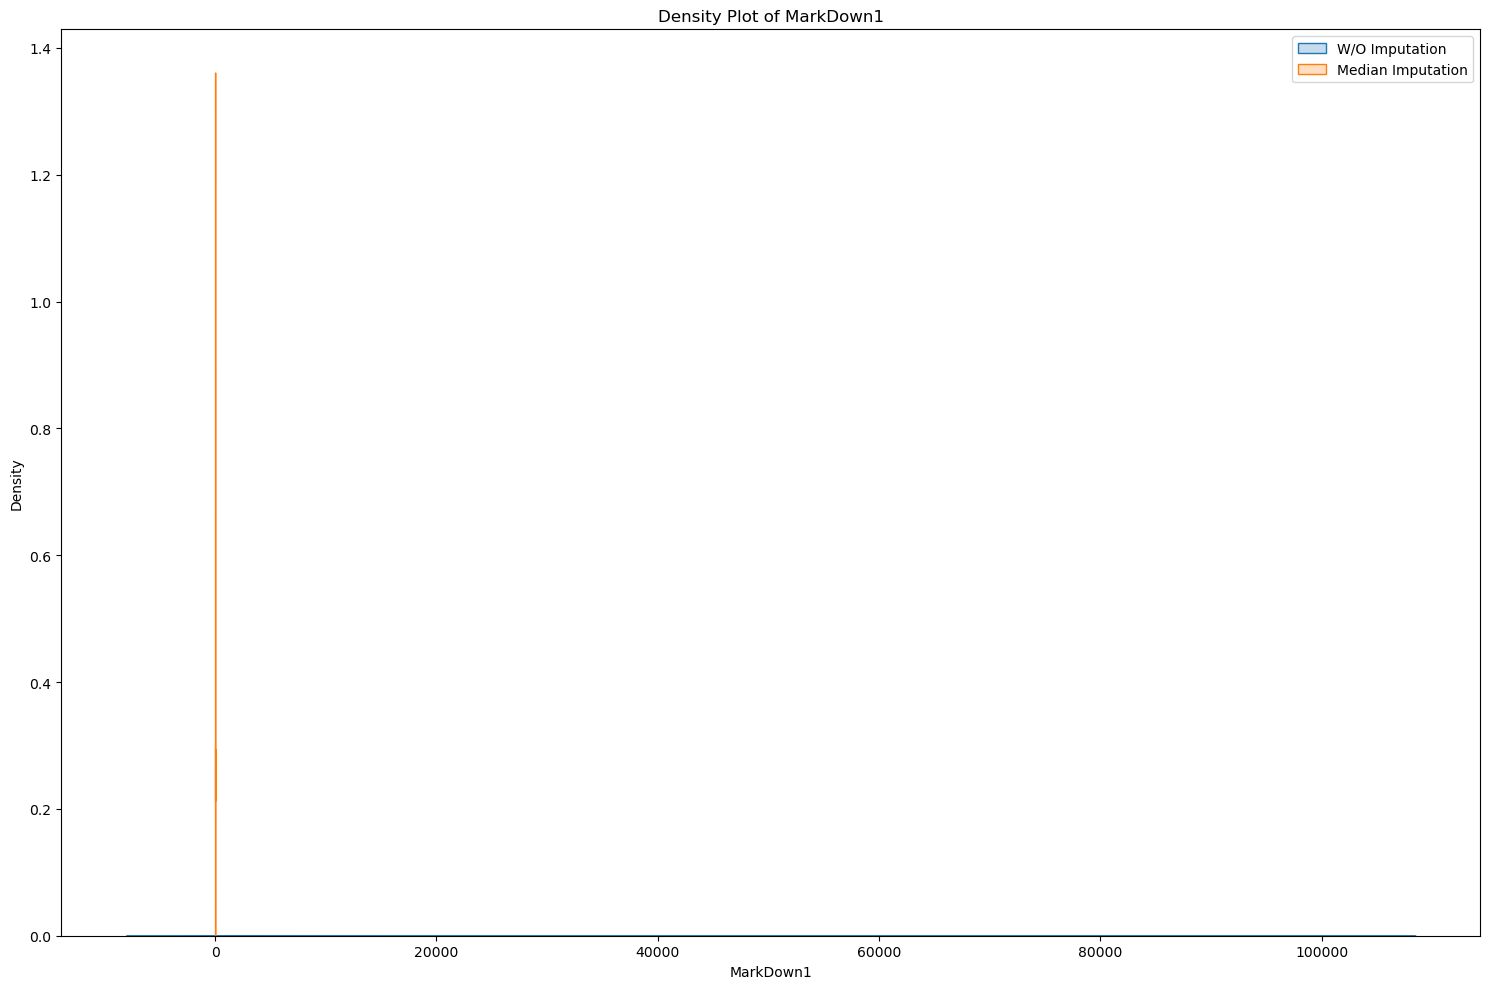

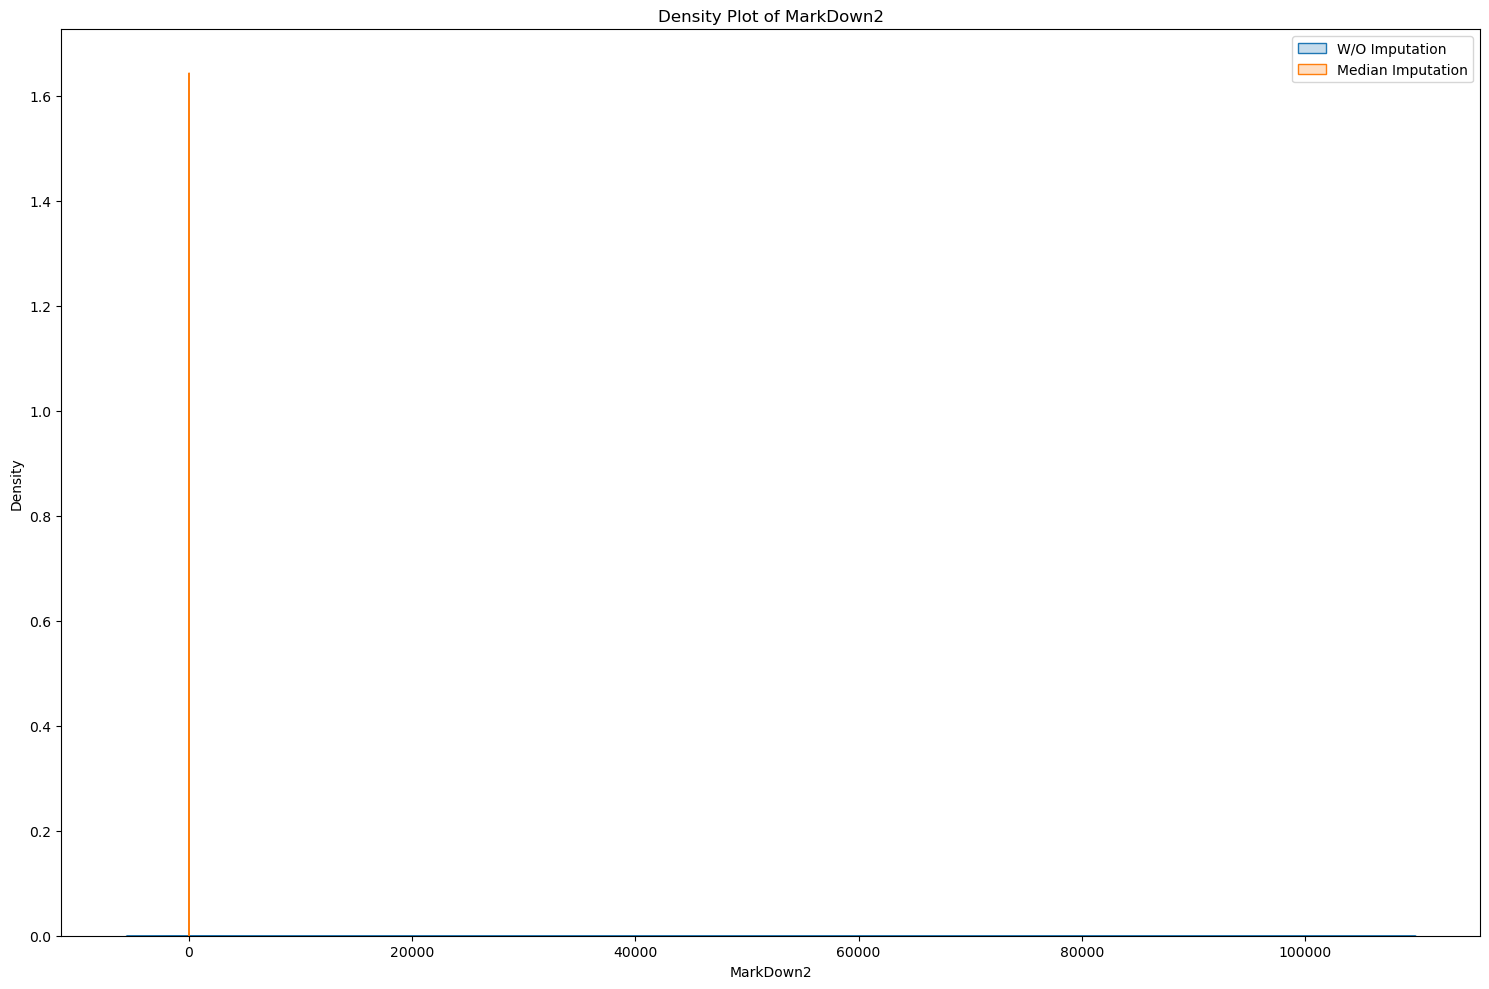

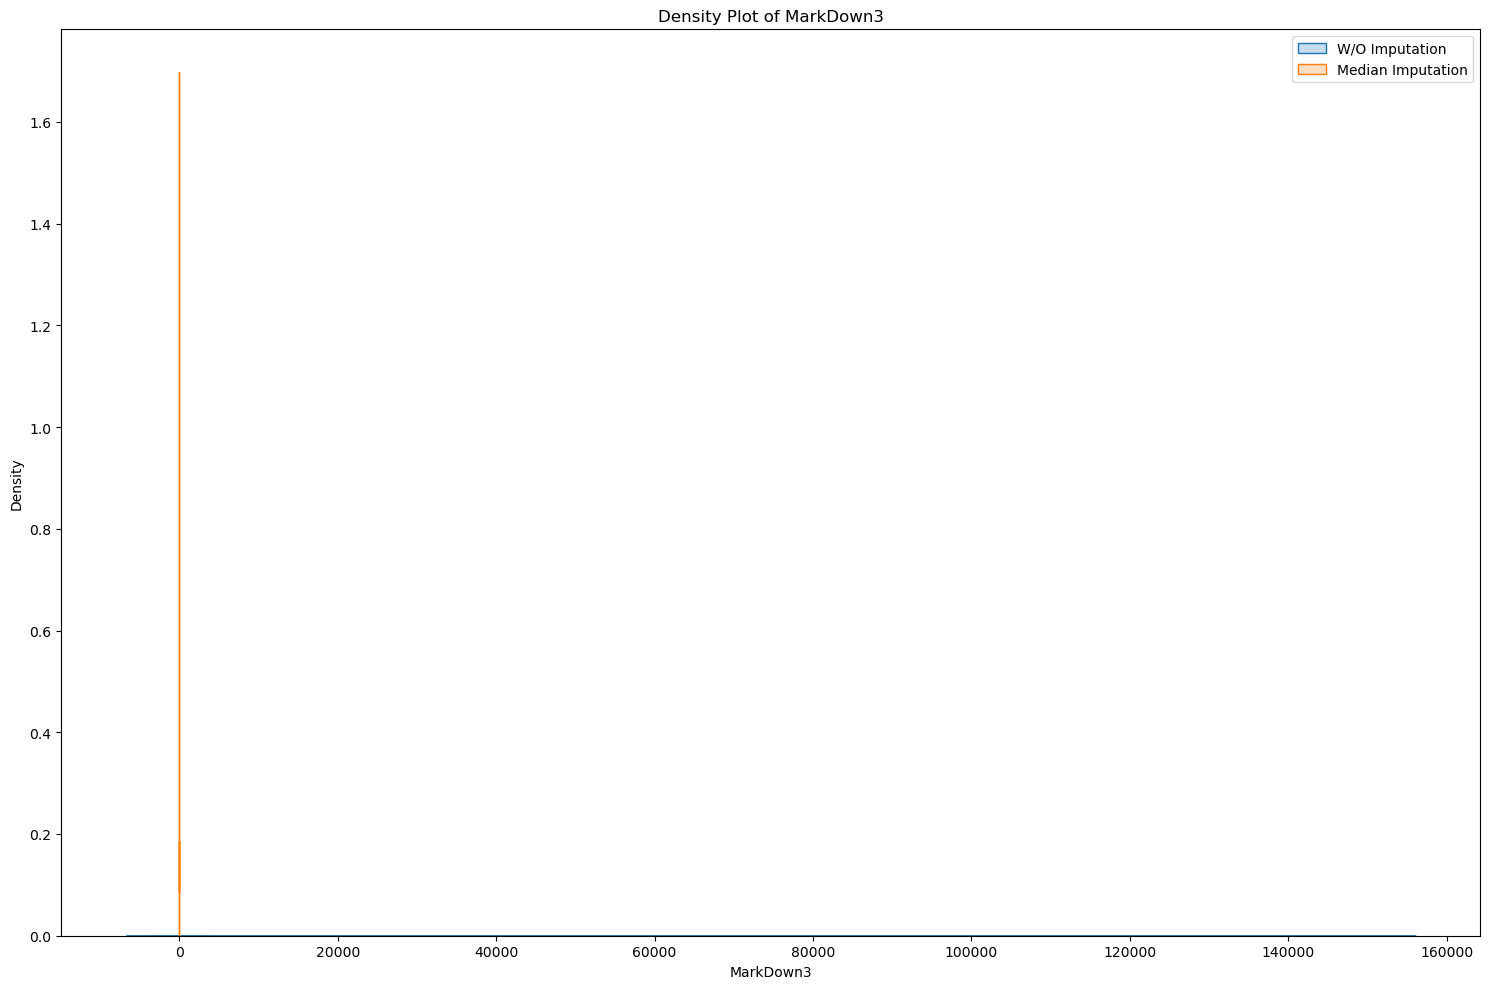

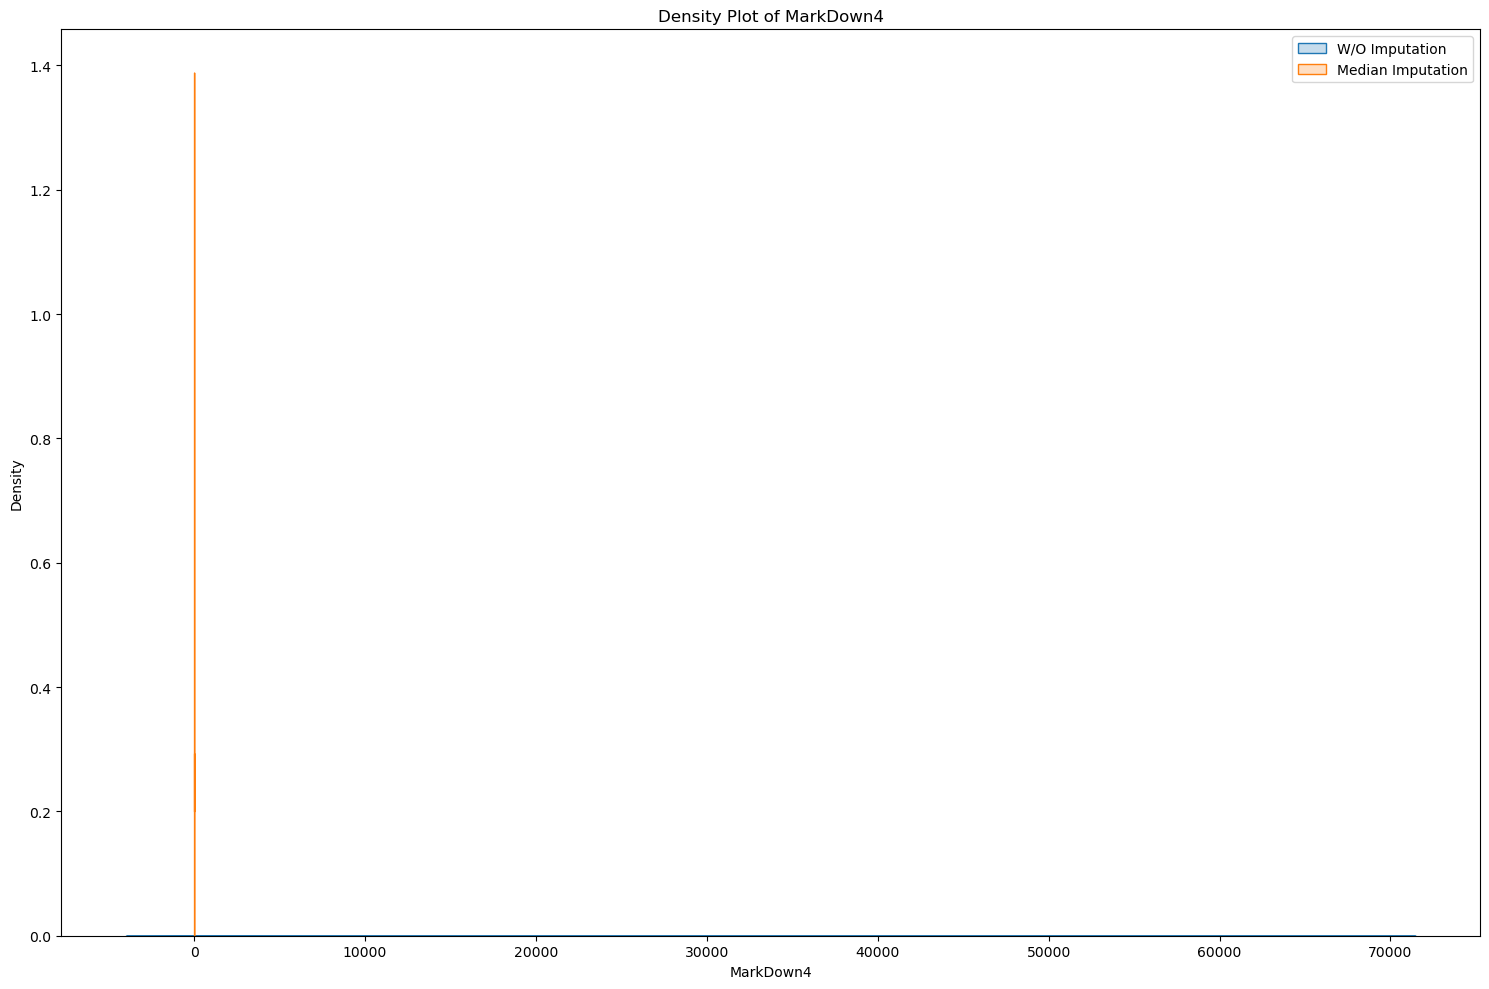

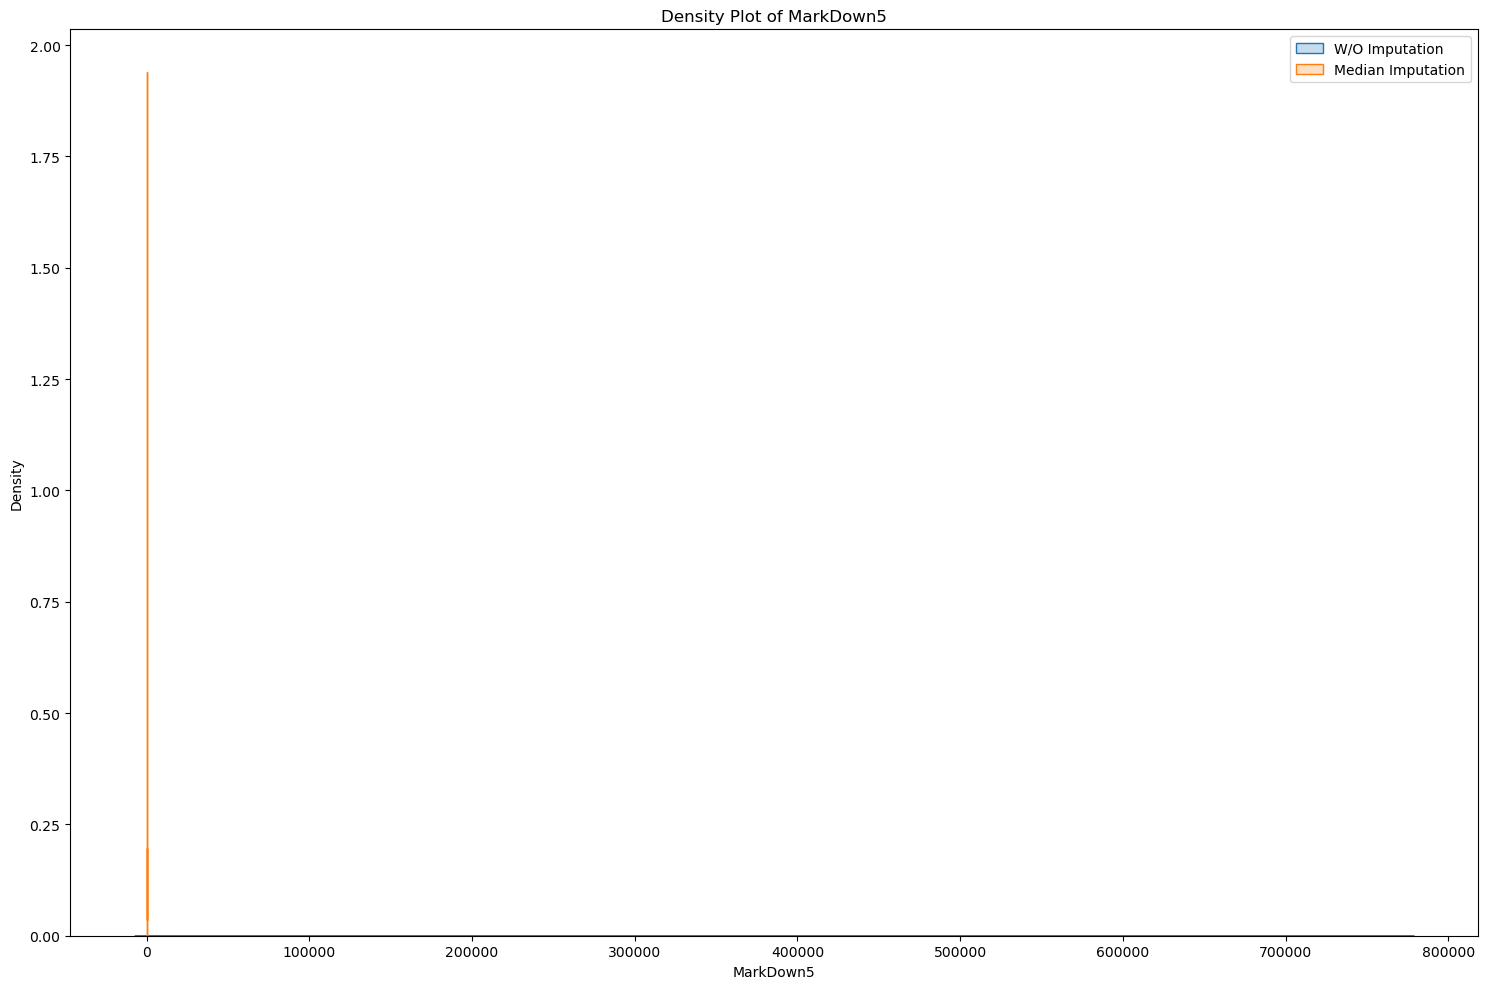

In [64]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Wizualizacja porównawcza rozkładów danych


for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    plt.hist(merged_data_W_imp[col].dropna(), bins=500, alpha=0.3, label='W/O Imputation')
    plt.hist(correlation_matrix_median_imp[col].dropna(), bins=500, alpha=0.3, label='Median Imputation')
    # plt.xlim(0, 40000)
    plt.title(f'Comparison of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()



# plt.figure(figsize=(15, 10))

# for i, col in enumerate(markdown_columns, start=1):
#     # plt.subplot(6, 1, i)
#     plt.boxplot([merged_data_W_imp[col].dropna(), merged_data_no_empty[col].dropna()], labels=['W/O ', 'KNN'])
#     plt.title(f'Box Plot of {col}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()



for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    sns.kdeplot(merged_data_W_imp[col].dropna(), shade=True, label='W/O Imputation')
    sns.kdeplot(correlation_matrix_median_imp[col].dropna(), shade=True, label='Median Imputation')
    # plt.xlim(0, 40000)
    plt.title(f'Density Plot of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


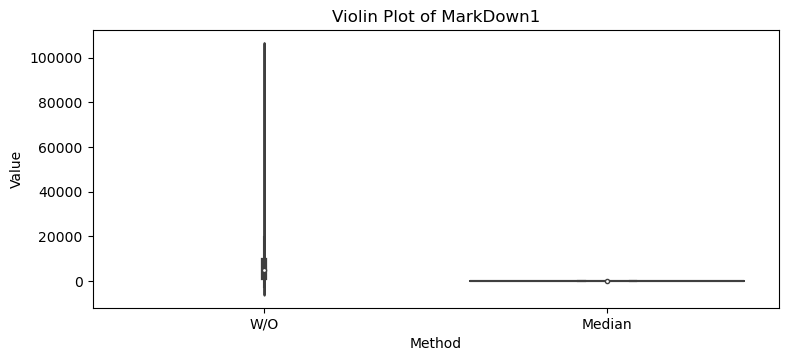

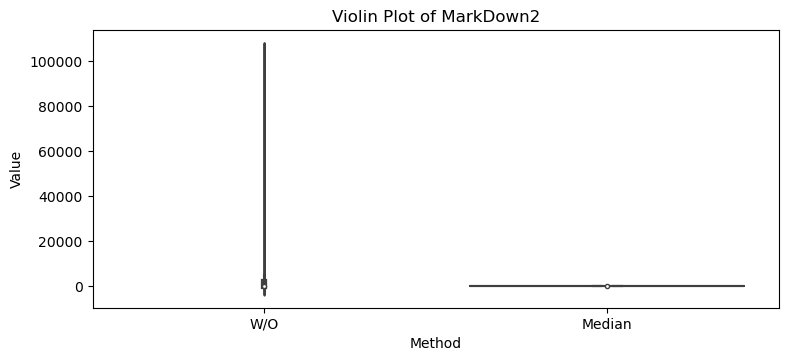

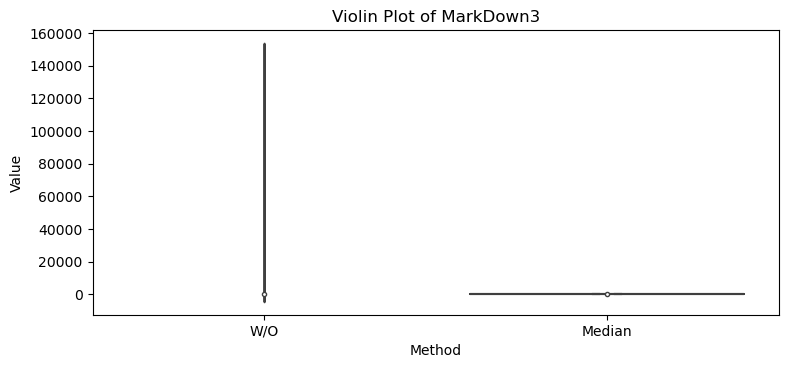

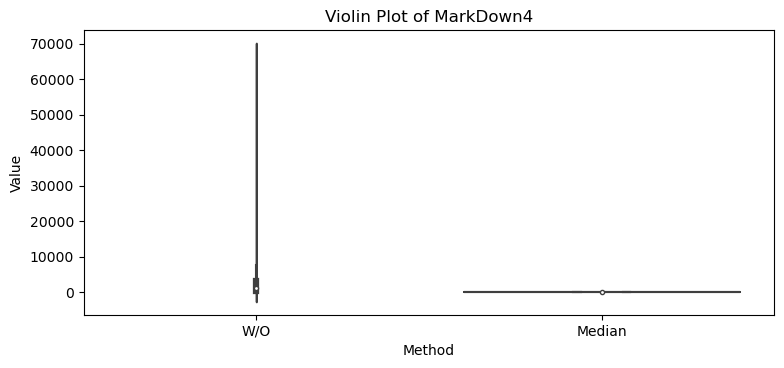

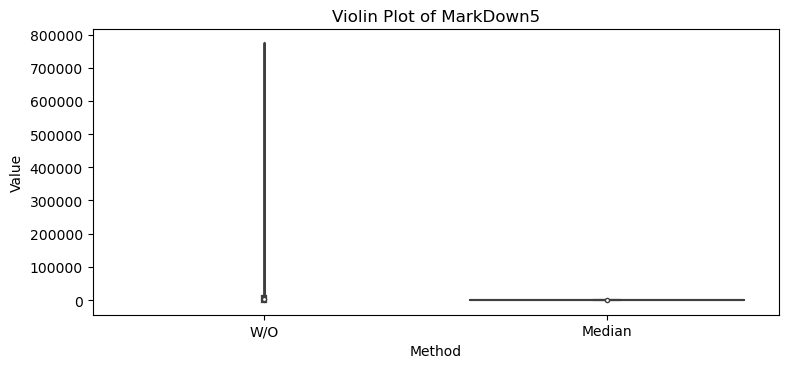

In [65]:
data_melted = pd.DataFrame()
for col in markdown_columns:
    temp_df = pd.DataFrame({
        'Value': merged_data_W_imp[col].dropna(),
        'Column': col,
        'Method': 'W/O'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)
    
    temp_df = pd.DataFrame({
        'Value': correlation_matrix_median_imp[col].dropna(),
        'Column': col,
        'Method': 'Median'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)

# Wizualizacja porównawcza rozkładów danych za pomocą violin plotów


for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 2, i)
    sns.violinplot(x='Method', y='Value', data=data_melted[data_melted['Column'] == col])
    plt.title(f'Violin Plot of {col}')
    plt.tight_layout()
    plt.show()


Media work much worse i decide to delete empty rows

In [68]:
merged_data_final=merged_data_W_imp.copy()
merged_data_final.dropna(inplace=True)
print('Before drop: ',merged_data_W_imp.shape)

print('After drop: ',merged_data_final.shape)


Before drop:  (8190, 13)
After drop:  (2520, 13)


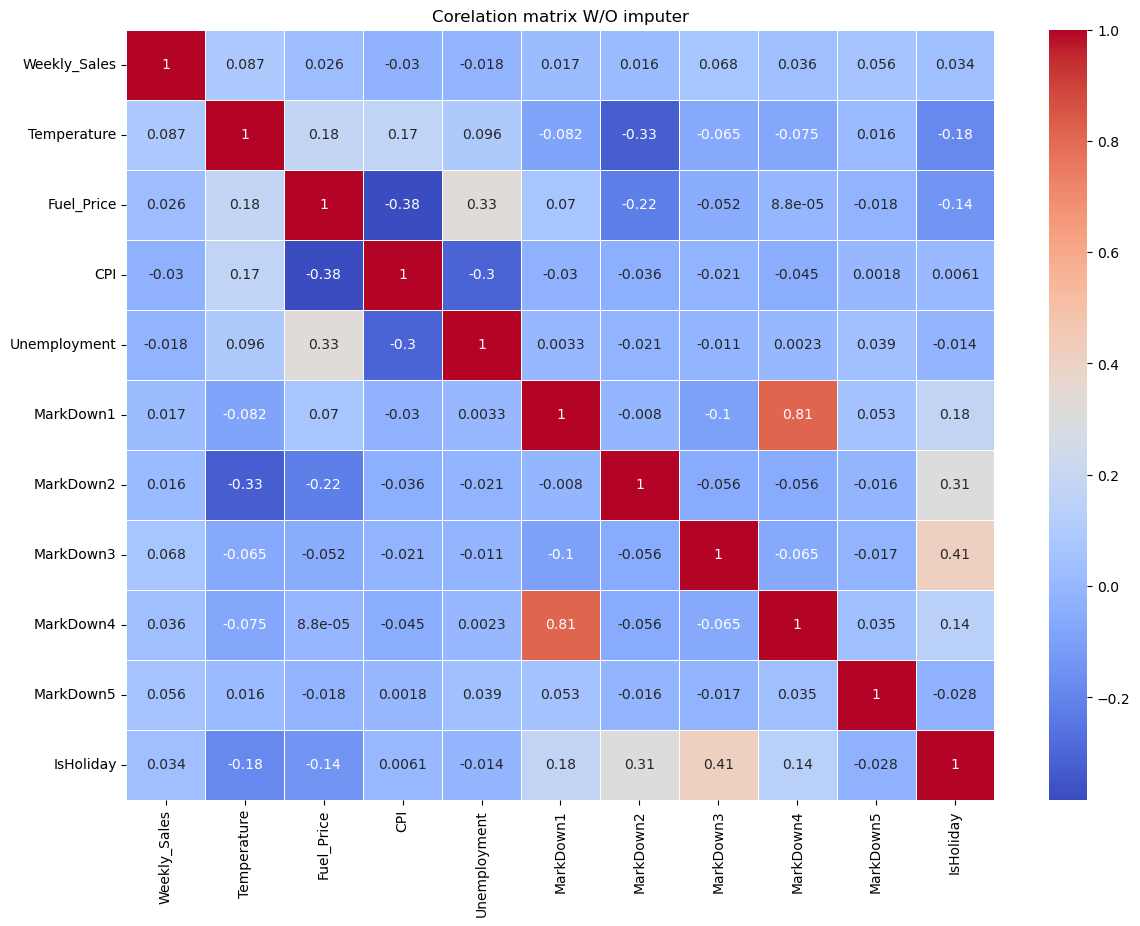

In [69]:
corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']

# Obliczenie macierzy korelacji
correlation_matrix_final = merged_data_final[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

after removal, significant differences in correlation appeared so I will try to make 2 clustering attempts, one before removing markdown without using markdown, the other after removing markdown